In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import missingno as msno
import datetime as dt
import pickle
import re
import ast
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

In [124]:

# Importing data from different cities

chennai=pd.read_excel("D:\Data Science\Python.VS\sownd\project 3 cardekho\chennai_cars.xlsx")
delhi=pd.read_excel("D:\Data Science\Python.VS\sownd\project 3 cardekho\delhi_cars.xlsx")
hyderabad=pd.read_excel("D:\Data Science\Python.VS\sownd\project 3 cardekho\hyderabad_cars.xlsx")
jaipur=pd.read_excel("D:\Data Science\Python.VS\sownd\project 3 cardekho\jaipur_cars.xlsx")
kolkata=pd.read_excel("D:\Data Science\Python.VS\sownd\project 3 cardekho\kolkata_cars.xlsx")
bangalore=pd.read_excel(r"D:\Data Science\Python.VS\sownd\project 3 cardekho\bangalore_cars.xlsx")

In [125]:
# Adding city column
chennai['City'] = 'Chennai'
delhi['City'] = 'Delhi'
hyderabad['City'] = 'Hyderabad'
jaipur['City'] = 'Jaipur'
kolkata['City'] = 'Kolkata'
bangalore['City'] = 'Bangalore'

In [126]:
# Merging datasets
merged_df = pd.concat([chennai, delhi, hyderabad, jaipur, kolkata, bangalore], ignore_index=True)
# Saving to CSV and reloading
merged_df.to_csv("merged_cardata.csv", index=False)
merged_cardata = pd.read_csv("merged_cardata.csv")
# Printing and checking dataset info
print(merged_cardata)
merged_cardata.info()

                                         new_car_detail  \
0     {'it': 0, 'ft': 'Petrol', 'bt': 'SUV', 'km': '...   
1     {'it': 0, 'ft': 'Petrol', 'bt': 'Minivans', 'k...   
2     {'it': 0, 'ft': 'Petrol', 'bt': 'SUV', 'km': '...   
3     {'it': 0, 'ft': 'Petrol', 'bt': 'Hatchback', '...   
4     {'it': 0, 'ft': 'Petrol', 'bt': 'Hatchback', '...   
...                                                 ...   
8364  {'it': 0, 'ft': 'Diesel', 'bt': 'SUV', 'km': '...   
8365  {'it': 0, 'ft': 'Petrol', 'bt': 'Sedan', 'km':...   
8366  {'it': 0, 'ft': 'Petrol', 'bt': 'Hatchback', '...   
8367  {'it': 0, 'ft': 'Diesel', 'bt': 'Hatchback', '...   
8368  {'it': 0, 'ft': 'Petrol', 'bt': 'Hatchback', '...   

                                       new_car_overview  \
0     {'heading': 'Car overview', 'top': [{'key': 'R...   
1     {'heading': 'Car overview', 'top': [{'key': 'R...   
2     {'heading': 'Car overview', 'top': [{'key': 'R...   
3     {'heading': 'Car overview', 'top': [{'key': 'R...

In [127]:
df = pd.read_csv('merged_cardata.csv')
# Converting string representations of dictionaries to actual dictionaries
df['new_car_detail_dict'] = df['new_car_detail'].apply(ast.literal_eval)
df['new_car_overview_dict'] = df['new_car_overview'].apply(ast.literal_eval)
df['new_car_feature_dict'] = df['new_car_feature'].apply(ast.literal_eval)
df['new_car_specs_dict'] = df['new_car_specs'].apply(ast.literal_eval)

# Normalizing 'new_car_detail_dict'
df_normalized = pd.json_normalize(df['new_car_detail_dict'])

# Extracting 'top' overview information
df['top'] = df['new_car_overview_dict'].apply(lambda x: x.get('top') if pd.notnull(x) else [])
df_overview = df['top'].apply(lambda x: pd.Series({item['key']: item['value'] for item in x}))

In [128]:
# Function to extract features
def extract_features(feature_dict):
    features = set()
    if 'top' in feature_dict and feature_dict['top'] is not None:
        for item in feature_dict['top']:
            features.add(item['value'])
    if 'data' in feature_dict and feature_dict['data'] is not None:
        for section in feature_dict['data']:
            for item in section['list']:
                features.add(item['value'])
    return pd.Series({feature: True for feature in features})

df_features = df['new_car_feature_dict']

# Function to extract specs
def extract_specs(specs_dict):
    specs = {}
    if 'top' in specs_dict and specs_dict['top'] is not None:
        for item in specs_dict['top']:
            specs[item['key']] = item['value']
    if 'data' in specs_dict and specs_dict['data'] is not None:
        for section in specs_dict['data']:
            for item in section['list']:
                specs[item['key']] = item['value']
    return pd.Series(specs)

df_specs = df['new_car_specs_dict'].apply(extract_specs)

In [129]:
import pandas as pd
import ast

def extract_features(data):
    """
    Extracts features from a list of dictionaries and returns a dictionary
    with keys as feature names and values as feature values.
    """
    if isinstance(data, str):
        try:
            data = ast.literal_eval(data)
        except (ValueError, SyntaxError):
            return None
    if isinstance(data, list) and all(isinstance(item, dict) for item in data):
        features = {}
        for item in data:
            key = item.get('key')
            value = item.get('value')
            features[key] = value
        return features
    else:
        return None

# Assuming your DataFrame is called 'df' and the column with the list of dictionaries is named 'top'
df['extracted_features'] = df['top'].apply(extract_features)

# Create separate columns for each feature
df = pd.concat([df, df['extracted_features'].apply(pd.Series)], axis=1)

# Drop the intermediate columns
df = df.drop(columns=['top', 'extracted_features'])

# Display the first 5 rows of the DataFrame with the extracted features
print(df.head().to_markdown(index=False, numalign="left", stralign="left"))

| new_car_detail                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           | new_car_overview                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

In [130]:
# Concatenating all extracted and normalized data
df = pd.concat([df, df_normalized, df_overview, df_features, df_specs], axis=1)
# Dropping unnecessary columns
df.drop(columns=['new_car_detail', 'new_car_detail_dict', 'new_car_overview', 'new_car_overview_dict', 'new_car_feature', 'new_car_feature_dict', 'new_car_specs', 'new_car_specs_dict'], inplace=True)

df = df.loc[:, ~df.columns.duplicated()]

print(df.columns)
df.info()

Index(['car_links', 'City', 'Registration Year', 'Insurance Validity',
       'Fuel Type', 'Seats', 'Kms Driven', 'RTO', 'Ownership',
       'Engine Displacement', 'Transmission', 'Year of Manufacture', 'it',
       'ft', 'bt', 'km', 'transmission', 'ownerNo', 'owner', 'oem', 'model',
       'modelYear', 'centralVariantId', 'variantName', 'price', 'priceActual',
       'priceSaving', 'priceFixedText', 'trendingText.imgUrl',
       'trendingText.heading', 'trendingText.desc', 'Engine', 'Max Power',
       'Torque', 'Wheel Size', 'Color', 'Engine Type', 'Displacement',
       'Max Torque', 'No of Cylinder', 'Values per Cylinder',
       'Fuel Suppy System', 'Turbo Charger', 'Length', 'Width', 'Height',
       'Wheel Base', 'Kerb Weight', 'Gear Box', 'Drive Type',
       'Seating Capacity', 'Steering Type', 'Front Brake Type',
       'Rear Brake Type', 'Tyre Type', 'Alloy Wheel Size', 'No Door Numbers',
       'Cargo Volumn', 'Mileage', 'Value Configuration', 'Compression Ratio',
       '

In [131]:
import pandas as pd
import numpy as np

def convert_to_numeric(df, cols):
    """Converts specified columns to numeric, handling common string formats."""
    for col in cols:
        print(f"Processing column: {col}")
        print(f"Column dtype: {df[col].dtype}")
        print(f"Unique values before cleaning: {df[col].unique()}") # Debugging: Print unique values before cleaning

        # Replace empty strings and common string representations of missing values with NaN
        df[col] = df[col].replace(['', 'nan', 'None'], np.nan)

        # Specific string cleaning for certain columns
        if col == 'Kms Driven':
            df[col] = df[col].str.replace(',', '', regex=False).str.replace(' Kms', '', regex=False)
        elif col == 'Engine Displacement':
            df[col] = df[col].str.replace(' cc', '', regex=False)
        elif col == 'Max Power':
            df[col] = df[col].str.replace(' bhp', '', regex=False).str.replace(' PS', '', regex=False)
        elif col == 'Torque':
            df[col] = df[col].str.replace(' Nm', '', regex=False)

        print(f"Unique values after cleaning: {df[col].unique()}") # Debugging: Print unique values after cleaning

        # Convert to numeric, coercing errors to NaN
        df[col] = pd.to_numeric(df[col], errors='coerce')
    return df


# Numerical and categorical columns (as defined in your original code)
numerical_cols = ['priceActual', 'priceSaving', 'priceFixedText', 'Registration Year', 'Seats', 'Kms Driven',
                  'Engine Displacement', 'Year of Manufacture', 'Max Power', 'Torque', 'Wheel Size',
                  'Length', 'Width', 'Height', 'Wheel Base', 'Kerb Weight', 'Gear Box',
                  'Drive Type', 'Seating Capacity', 'Steering Type', 'Front Brake Type', 'Rear Brake Type',
                  'Tyre Type', 'Alloy Wheel Size', 'No Door Numbers', 'Cargo Volumn', 'Mileage',
                  'Value Configuration', 'Compression Ratio', 'Super Charger', 'Front Tread', 'Rear Tread',
                  'Gross Weight', 'Turning Radius', 'Top Speed', 'Acceleration', 'BoreX Stroke',
                  'Ground Clearance Unladen']

categorical_cols = ['bt', 'Insurance Validity', 'RTO', 'Ownership', 'Engine', 'Color', 'Engine Type',
                    'Max Torque', 'No of Cylinder', 'Values per Cylinder', 'Turbo Charger', 'Steering Type']

# Print DataFrame info before conversion
print("DataFrame Info Before Numeric Conversion:")
df.info()
print("Null counts before conversion :")
print(df[['Seats', 'priceActual', 'priceSaving', 'priceFixedText', 'Max Power', 'Drive Type', 'Front Brake Type', 'Rear Brake Type', 'Tyre Type', 'Mileage', 'Value Configuration', 'Super Charger', 'BoreX Stroke']].isnull().sum())

# Convert to numeric
df = convert_to_numeric(df, numerical_cols)

# Impute missing values for numerical columns using median
for col in numerical_cols:
    if col in df.columns:
        median = df[col].median()
        df[col] = df[col].fillna(median)

# Impute missing values for categorical columns using mode
for col in categorical_cols:
    if col in df.columns:
        mode_values = df[col].mode()
        if not mode_values.empty:
            df[col] = df[col].fillna(mode_values[0])
        else:
            df[col] = df[col].fillna('Unknown')

# Confirming no missing values remain and print data types
print("\nDataFrame Info After Imputation:")
df.info()
print("\nData Types of Numerical Columns:")
print(df[numerical_cols].dtypes)

DataFrame Info Before Numeric Conversion:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8369 entries, 0 to 8368
Data columns (total 70 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   car_links                 8369 non-null   object 
 1   City                      8369 non-null   object 
 2   Registration Year         8317 non-null   object 
 3   Insurance Validity        8365 non-null   object 
 4   Fuel Type                 8369 non-null   object 
 5   Seats                     8363 non-null   object 
 6   Kms Driven                8367 non-null   object 
 7   RTO                       7481 non-null   object 
 8   Ownership                 8337 non-null   object 
 9   Engine Displacement       8365 non-null   object 
 10  Transmission              8369 non-null   object 
 11  Year of Manufacture       8349 non-null   float64
 12  it                        8369 non-null   int64  
 13  ft                   

C:\Users\SOWNDHARYA SRINATH\AppData\Local\Temp\ipykernel_111520\3721449722.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(['', 'nan', 'None'], np.nan)


Unique values after cleaning: [nan '15.37 kmpl' '20 kmpl' '19.81 kmpl' '18.7 kmpl' '13 kmpl' '23.1 kmpl'
 '19 kmpl' '16.55 kmpl' '14.8 kmpl' '21 kmpl' '18.2 kmpl' '20.37 kmpl'
 '22 kmpl' '18.9 kmpl' '21.5 kmpl' '17.1 kmpl' '17.4 kmpl' '18 kmpl'
 '20.3 kmpl' '25.2 kmpl' '17.8 kmpl' '17.01 kmpl' '18.15 kmpl'
 '13.53 kmpl' '21.4 kmpl' '8 kmpl' '17.5 kmpl' '27.3 kmpl' '15 kmpl'
 '15.9 kmpl' '19.6 kmpl' '20.7 kmpl' '14.53 kmpl' '16.82 kmpl'
 '21.43 kmpl' '28.4 kmpl' '17 kmpl' '18.53 kmpl' '13.22 kmpl' '25.5 kmpl'
 '28.09 kmpl' '14.75 kmpl' '13.68 kmpl' '19.27 kmpl' '16.46 kmpl'
 '17.74 kmpl' '14.08 kmpl' '19.02 kmpl' '18.41 kmpl' '23.8 kmpl'
 '16.8 kmpl' '14.6 kmpl' '17.52 kmpl' '20.36 kmpl' '18.6 kmpl' '16 kmpl'
 '15.5 kmpl' '16.2 kmpl' '23 kmpl' '19.12 kmpl' '14.3 kmpl' '20.14 kmpl'
 '24.52 kmpl' '16.35 kmpl' '16.09 kmpl' '12.51 kmpl' '15.6 kmpl'
 '17.99 kmpl' '19.4 kmpl' '15.81 kmpl' '13.5 kmpl' '13.6 kmpl'
 '18.49 kmpl' '21.21 kmpl' '15.26 kmpl' '20.38 kmpl' '21.66 kmpl'
 '19.1 kmpl' '2

c:\Users\SOWNDHARYA SRINATH\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1231: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\SOWNDHARYA SRINATH\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1231: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\SOWNDHARYA SRINATH\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1231: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\SOWNDHARYA SRINATH\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1231: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\SOWNDHARYA SRINATH\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1231: RuntimeW

In [132]:
# Identify columns with mixed data types
for column in df.columns:
    if df[column].apply(type).nunique() > 1:
        print(f'Column "{column}" has mixed types.')

Column "Displacement" has mixed types.
Column "Fuel Suppy System" has mixed types.


In [133]:
import pandas as pd
import numpy as np

def clean_displacement(displacement):
    """Cleans the 'Displacement' column."""
    if isinstance(displacement, str):
        displacement = displacement.replace('cc', '').replace(',', '').strip()
        try:
            return int(float(displacement)) #convert to int if possible.
        except ValueError:
            return np.nan #return nan if not possible.
    try:
        return int(displacement) #convert to int if possible.
    except ValueError:
        return np.nan #return nan if not possible.

def clean_fuel_supply(fuel_supply):
    """Cleans the 'Fuel Suppy System' column."""
    if isinstance(fuel_supply, str):
        return fuel_supply.strip().lower()  # Convert to lowercase and remove spaces
    return str(fuel_supply).strip().lower() #convert to string, then lowercase.

# Apply cleaning functions
df['Displacement'] = df['Displacement'].apply(clean_displacement)
df['Fuel Suppy System'] = df['Fuel Suppy System'].apply(clean_fuel_supply)

# Verify data types
print("Displacement dtype:", df['Displacement'].dtype)
print("Fuel Suppy System dtype:", df['Fuel Suppy System'].dtype)

# Handle potential NaNs in Displacement
df['Displacement'].fillna(0, inplace=True) #fill nan with 0 or other appropriate value.
df['Displacement'] = df['Displacement'].astype(int) #convert to int.

Displacement dtype: float64
Fuel Suppy System dtype: object


C:\Users\SOWNDHARYA SRINATH\AppData\Local\Temp\ipykernel_111520\3729470095.py:32: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Displacement'].fillna(0, inplace=True) #fill nan with 0 or other appropriate value.


In [134]:
# Function to clean price column
def clean_price(price):
    price = price.replace('₹', '').replace(',', '').strip()
    if 'Lakh' in price:
        price = price.replace('Lakh', '').strip()
        return float(price) * 1e5
    elif 'Crore' in price:
        price = price.replace('Crore', '').strip()
        return float(price) * 1e7
    return float(price)

# Apply the cleaning function to the price column
df['price'] = df['price'].apply(clean_price)

<Figure size 1500x800 with 0 Axes>

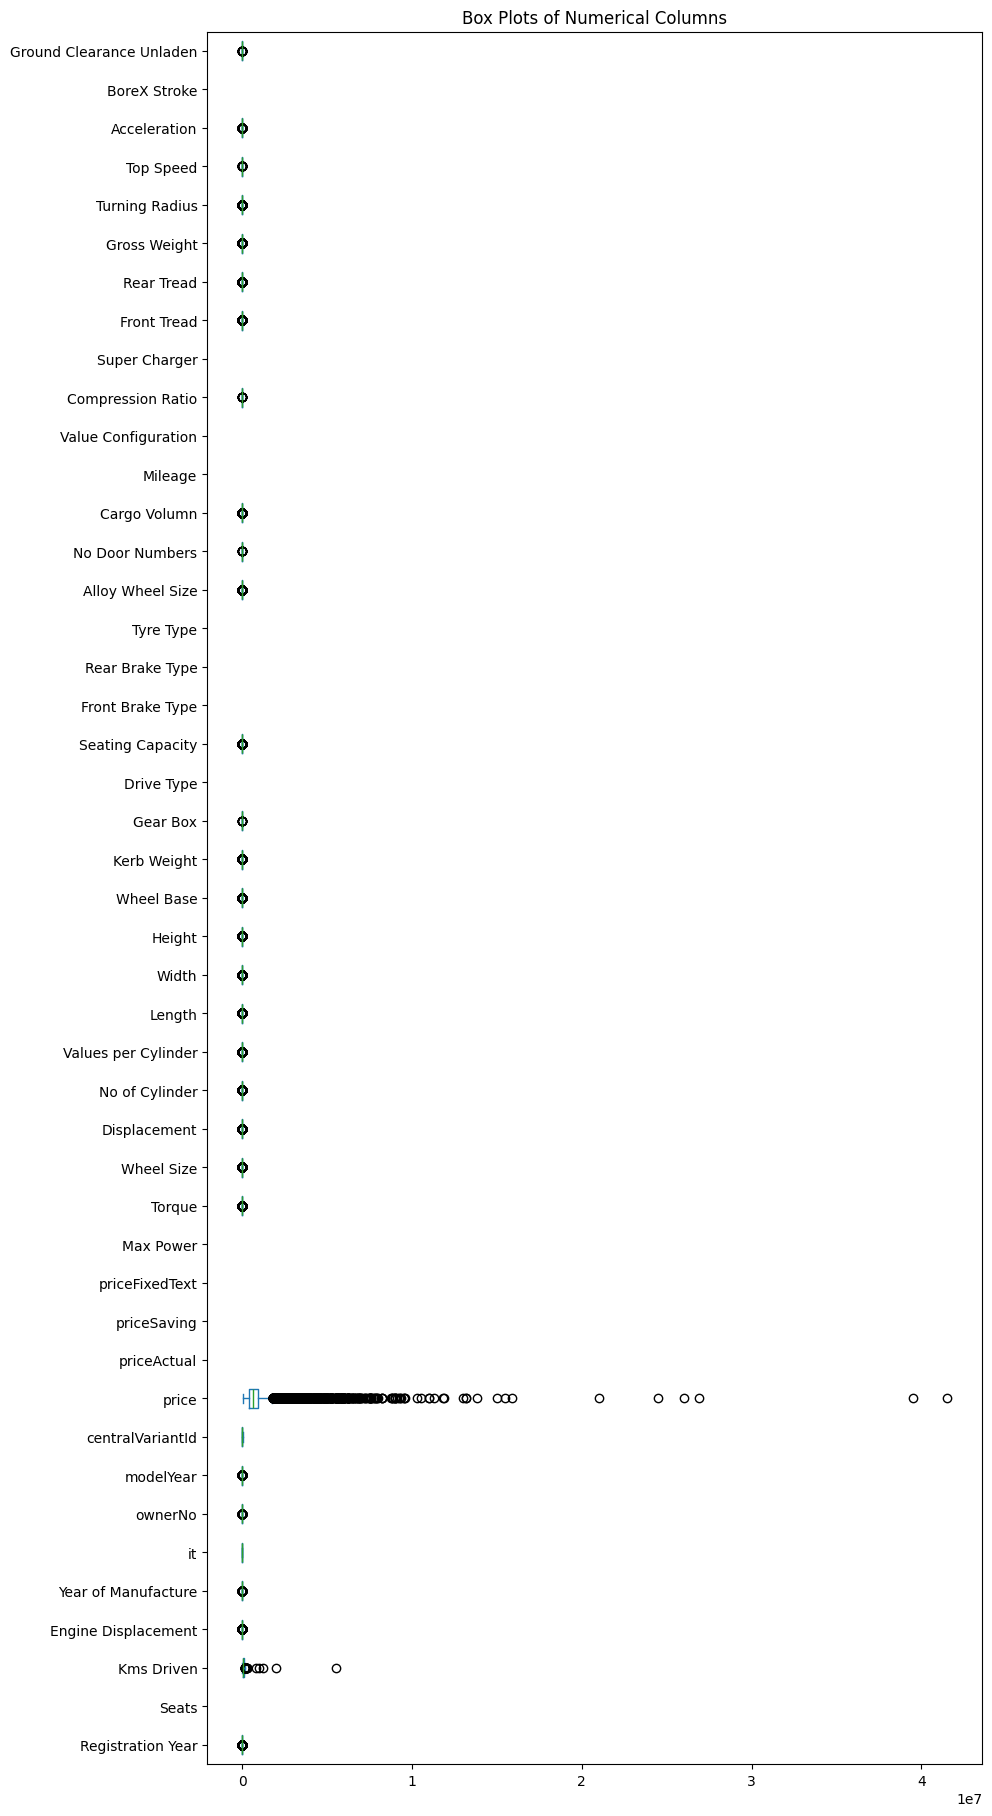

In [135]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming 'df' is your Pandas DataFrame

# Get all numerical columns
numerical_cols = df.select_dtypes(include=['number']).columns

# Create box plots for each numerical column
plt.figure(figsize=(15, 8))  # Adjust figure size for better readability
df[numerical_cols].plot(kind='box', vert=False, figsize=(10, len(numerical_cols) * 0.5))
plt.title("Box Plots of Numerical Columns")
plt.show()

import pandas as pd
import matplotlib.pyplot as plt

def find_and_winsorize_numerical_outliers(df):
    """
    Finds outliers in all numerical columns using IQR, winsorizes if found, 
    and visualizes the results.
    """

    numerical_cols = df.select_dtypes(include=['number']).columns

    for column in numerical_cols:
        q1 = df[column].quantile(0.25)
        q3 = df[column].quantile(0.75)
        iqr = q3 - q1

        outliers = df[(df[column] < (q1 - 1.5 * iqr)) | (df[column] > (q3 + 1.5 * iqr))]

        if not outliers.empty:
            print(f"Outliers found in {column}:")
            print(f"Outlier count in {column}: {len(outliers)}\n")

            # Winsorize using 25th and 75th percentiles
            df[column] = df[column].clip(lower=q1, upper=q3)

            print(f"Winsorization applied to {column}:")
            print(f"Lower bound: {q1}, Upper bound: {q3}")
            print(df[column].describe())

            plt.figure(figsize=(10, 6))
            plt.boxplot(df[column])
            plt.title(f'Box Plot of {column} (After Winsorization)')
            plt.ylabel(column)
            plt.show()

        else:
            print(f"No outliers found in {column}.\n")

# Example Usage:
# Assuming 'df' is your DataFrame
find_and_winsorize_numerical_outliers(df)

Outliers found in Registration Year:
Outlier count in Registration Year: 89

Capping applied to Registration Year:
Lower bound: 2006.0, Upper bound: 2022.0
count    8369.000000
mean     2015.849444
std         2.523037
min      2006.000000
25%      2016.000000
50%      2016.000000
75%      2016.000000
max      2022.000000
Name: Registration Year, dtype: float64


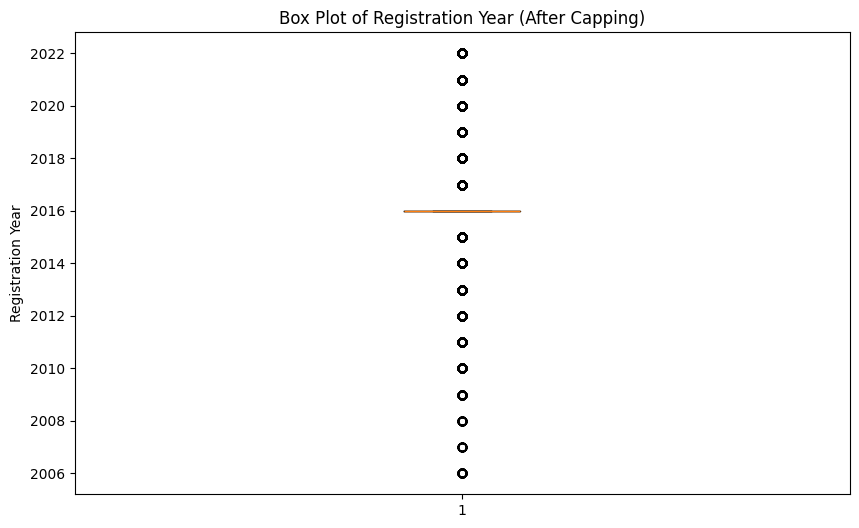

No outliers found in Seats.

Outliers found in Kms Driven:
Outlier count in Kms Driven: 146

Capping applied to Kms Driven:
Lower bound: 4023.1200000000003, Upper bound: 150000.0
count      8369.000000
mean      57664.860566
std       33668.449242
min        4023.120000
25%       30000.000000
50%       53700.000000
75%       80000.000000
max      150000.000000
Name: Kms Driven, dtype: float64


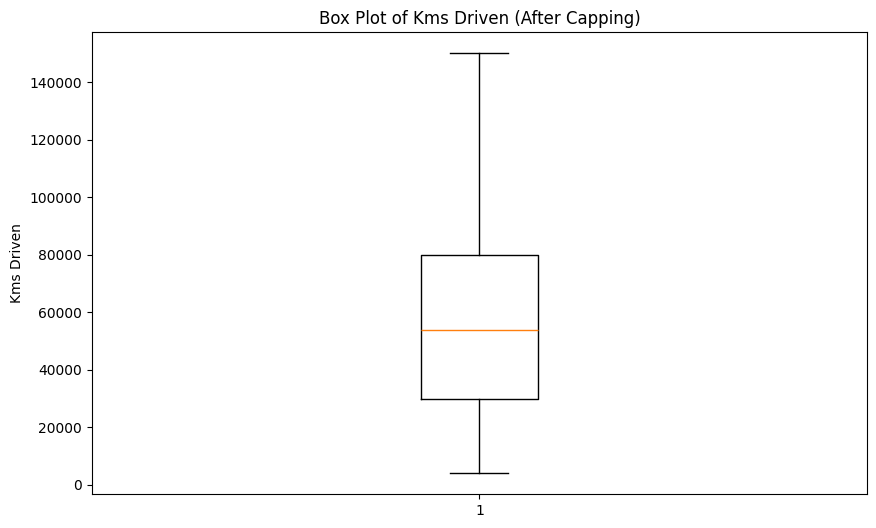

Outliers found in Engine Displacement:
Outlier count in Engine Displacement: 104

Capping applied to Engine Displacement:
Lower bound: 796.0, Upper bound: 2993.0
count    8369.000000
mean     1424.323217
std       457.184387
min       796.000000
25%      1197.000000
50%      1248.000000
75%      1498.000000
max      2993.000000
Name: Engine Displacement, dtype: float64


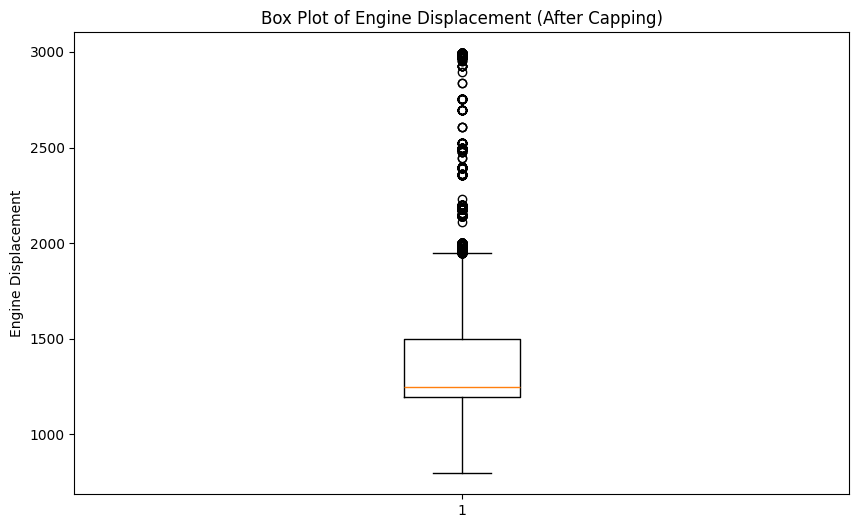

Outliers found in Year of Manufacture:
Outlier count in Year of Manufacture: 68

Capping applied to Year of Manufacture:
Lower bound: 2006.0, Upper bound: 2023.0
count    8369.000000
mean     2016.566734
std         3.751370
min      2006.000000
25%      2014.000000
50%      2017.000000
75%      2019.000000
max      2023.000000
Name: Year of Manufacture, dtype: float64


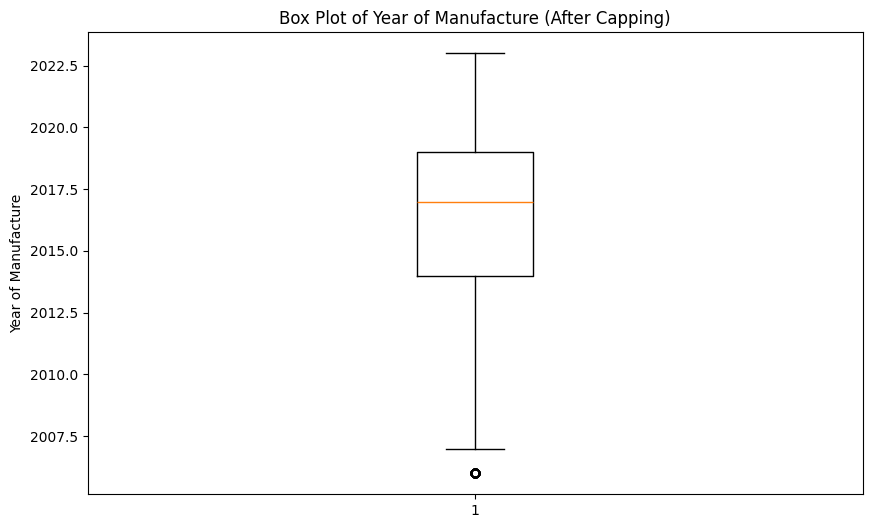

No outliers found in it.

Outliers found in ownerNo:
Outlier count in ownerNo: 51

Capping applied to ownerNo:
Lower bound: 1.0, Upper bound: 4.0
count    8369.000000
mean        1.361692
std         0.625517
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         4.000000
Name: ownerNo, dtype: float64


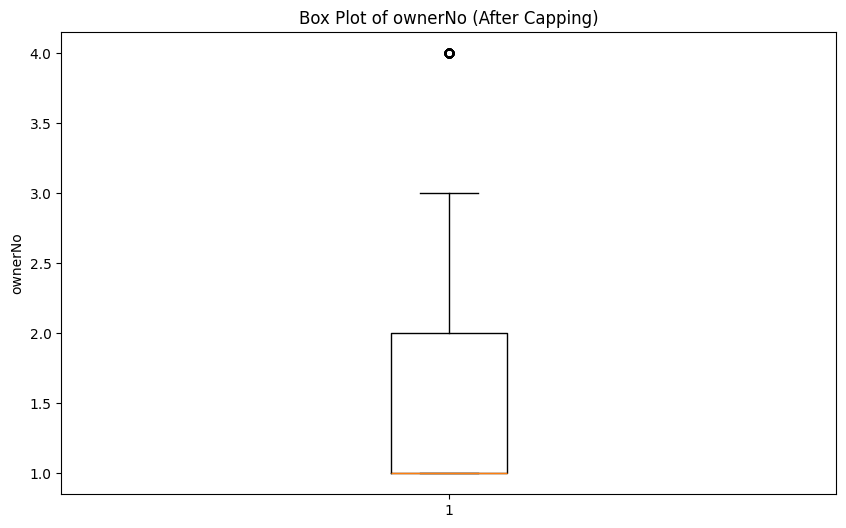

Outliers found in modelYear:
Outlier count in modelYear: 68

Capping applied to modelYear:
Lower bound: 2005.0, Upper bound: 2023.0
count    8369.000000
mean     2016.529932
std         3.817145
min      2005.000000
25%      2014.000000
50%      2017.000000
75%      2019.000000
max      2023.000000
Name: modelYear, dtype: float64


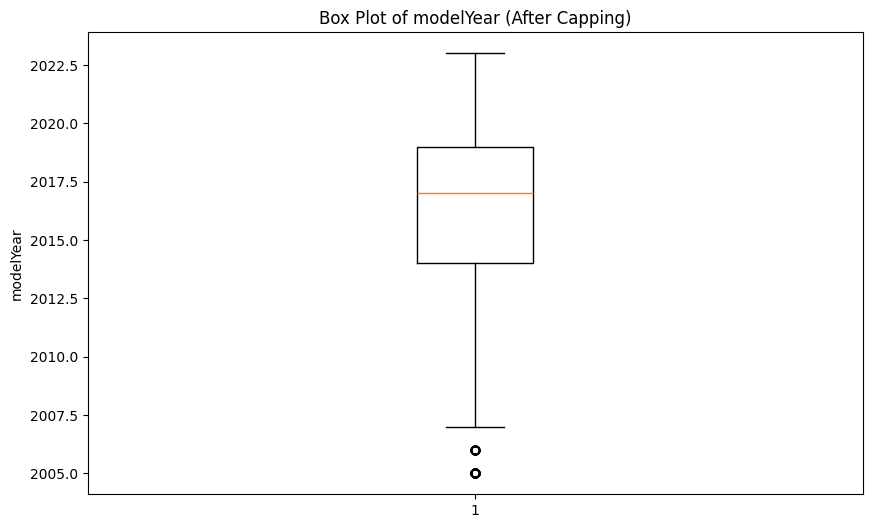

Outliers found in centralVariantId:
Outlier count in centralVariantId: 138

Capping applied to centralVariantId:
Lower bound: 112.0, Upper bound: 10403.0
count     8369.000000
mean      4962.046362
std       2743.979727
min        112.000000
25%       2042.000000
50%       5320.000000
75%       7121.000000
max      10403.000000
Name: centralVariantId, dtype: float64


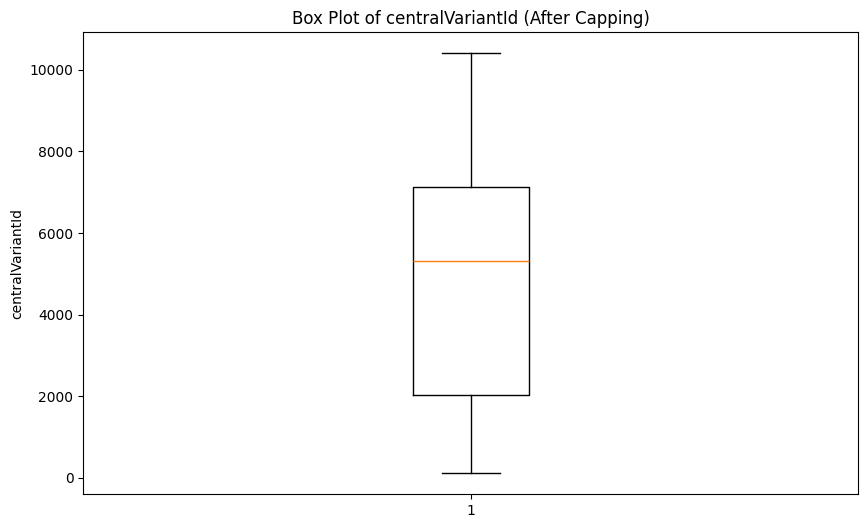

Outliers found in price:
Outlier count in price: 159

Capping applied to price:
Lower bound: 80000.0, Upper bound: 6215999.999999985
count    8.369000e+03
mean     9.189272e+05
std      1.029587e+06
min      8.000000e+04
25%      3.990000e+05
50%      6.010000e+05
75%      9.500000e+05
max      6.216000e+06
Name: price, dtype: float64


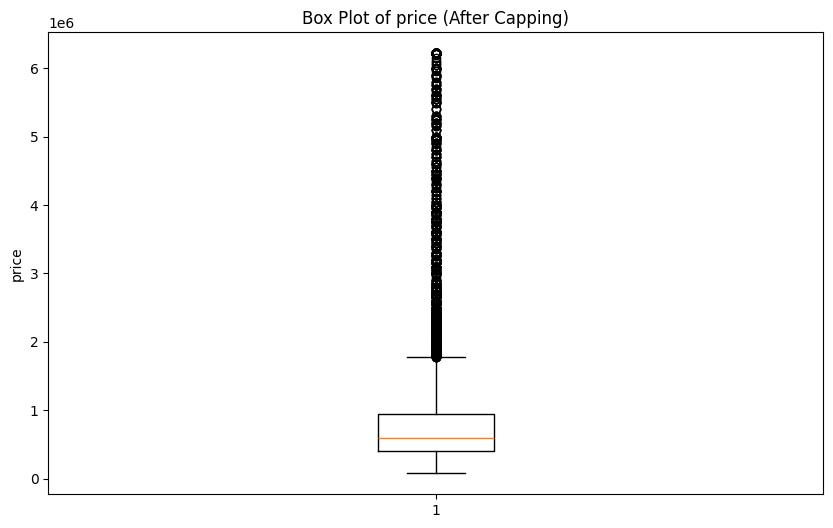

No outliers found in priceActual.

No outliers found in priceSaving.

No outliers found in priceFixedText.

No outliers found in Max Power.

Outliers found in Torque:
Outlier count in Torque: 152

Capping applied to Torque:
Lower bound: 20.4, Upper bound: 42.0
count    8369.000000
mean       25.627948
std         1.796178
min        20.400000
25%        25.500000
50%        25.500000
75%        25.500000
max        42.000000
Name: Torque, dtype: float64


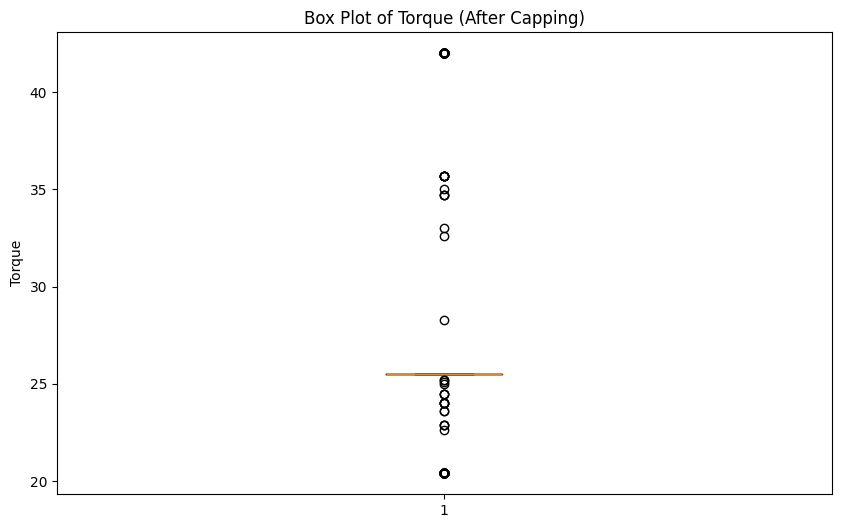

Outliers found in Wheel Size:
Outlier count in Wheel Size: 50

Capping applied to Wheel Size:
Lower bound: 12.0, Upper bound: 19.0
count    8369.000000
mean       15.790656
std         1.183520
min        12.000000
25%        15.000000
50%        16.000000
75%        16.000000
max        19.000000
Name: Wheel Size, dtype: float64


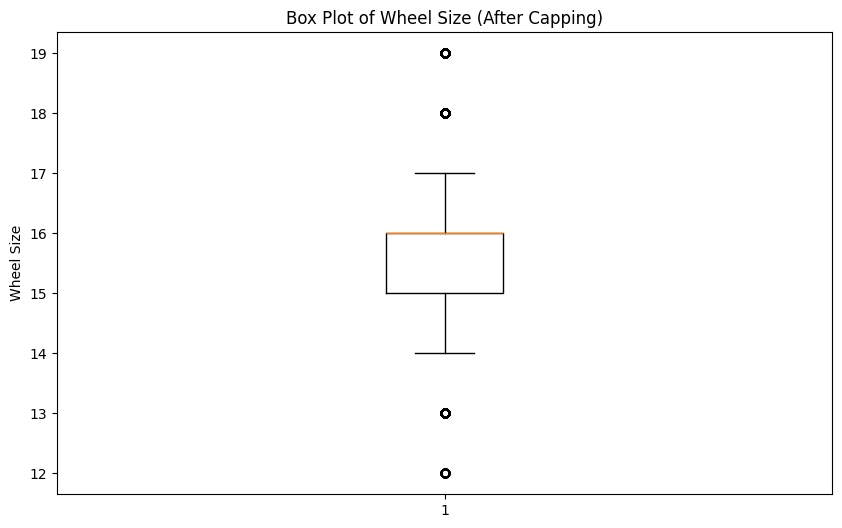

Outliers found in Displacement:
Outlier count in Displacement: 108

Capping applied to Displacement:
Lower bound: 796.0, Upper bound: 2993.0
count    8369.000000
mean     1424.107181
std       457.374431
min       796.000000
25%      1197.000000
50%      1248.000000
75%      1498.000000
max      2993.000000
Name: Displacement, dtype: float64


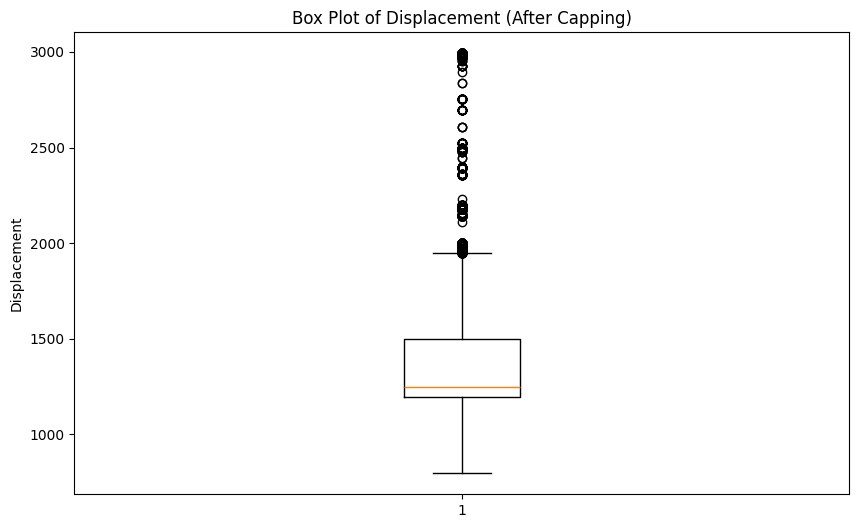

Outliers found in No of Cylinder:
Outlier count in No of Cylinder: 41

Capping applied to No of Cylinder:
Lower bound: 3.0, Upper bound: 6.0
count    8369.000000
mean        3.798542
std         0.526808
min         3.000000
25%         4.000000
50%         4.000000
75%         4.000000
max         6.000000
Name: No of Cylinder, dtype: float64


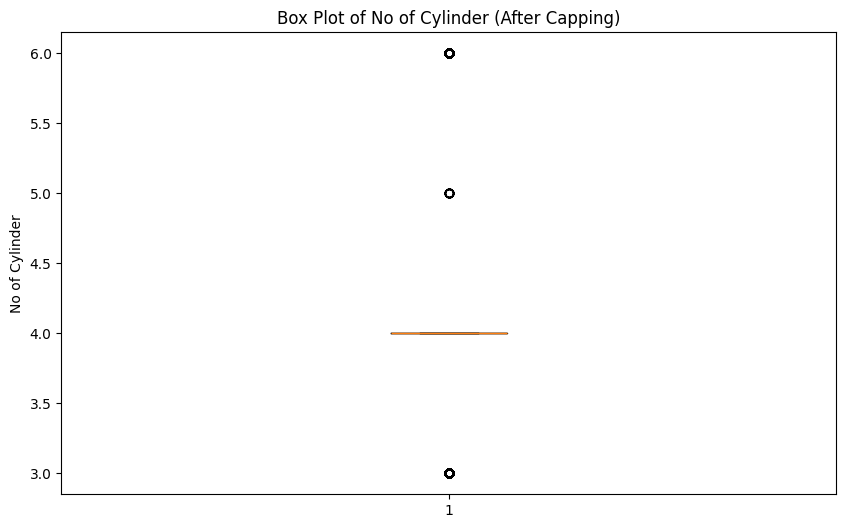

Outliers found in Values per Cylinder:
Outlier count in Values per Cylinder: 5

Capping applied to Values per Cylinder:
Lower bound: 2.0, Upper bound: 4.0
count    8369.000000
mean        3.926515
std         0.343578
min         2.000000
25%         4.000000
50%         4.000000
75%         4.000000
max         4.000000
Name: Values per Cylinder, dtype: float64


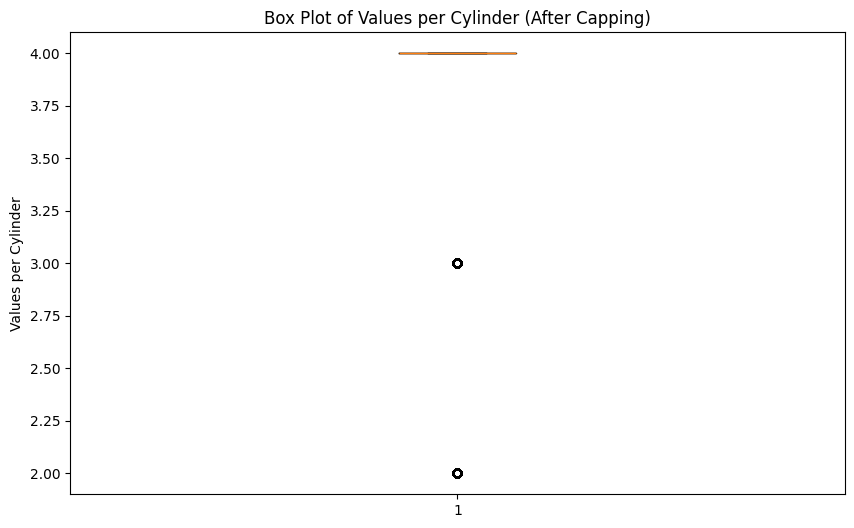

Outliers found in Length:
Outlier count in Length: 139

Capping applied to Length:
Lower bound: 3565.0, Upper bound: 4360.0
count    8369.000000
mean     3991.777154
std        64.340380
min      3565.000000
25%      3993.000000
50%      3993.000000
75%      3993.000000
max      4360.000000
Name: Length, dtype: float64


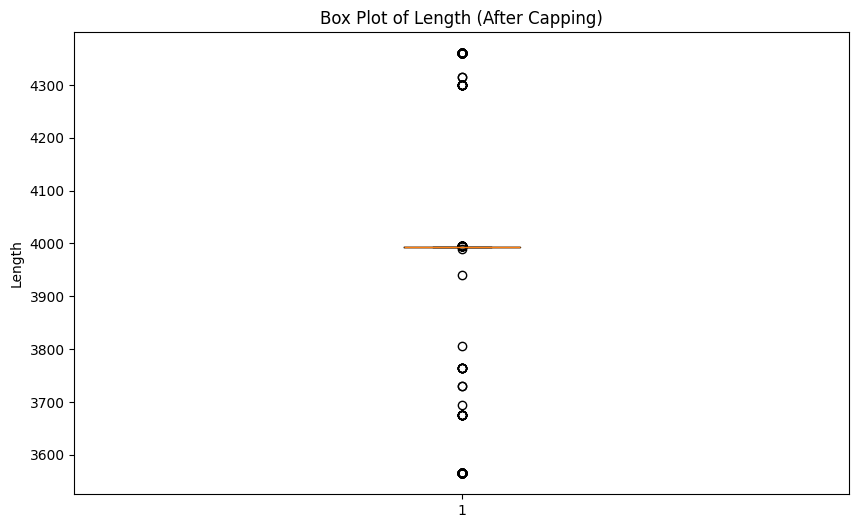

Outliers found in Width:
Outlier count in Width: 111

Capping applied to Width:
Lower bound: 1515.0, Upper bound: 1811.0
count    8369.000000
mean     1730.983989
std        33.013841
min      1515.000000
25%      1735.000000
50%      1735.000000
75%      1735.000000
max      1811.000000
Name: Width, dtype: float64


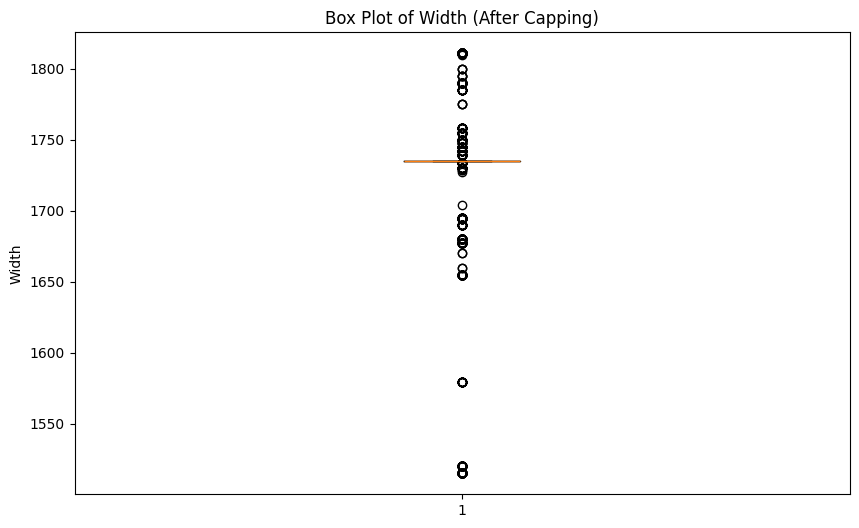

Outliers found in Height:
Outlier count in Height: 160

Capping applied to Height:
Lower bound: 1481.8000000000002, Upper bound: 1685.0
count    8369.000000
mean     1535.499964
std        23.107326
min      1481.800000
25%      1532.000000
50%      1532.000000
75%      1532.000000
max      1685.000000
Name: Height, dtype: float64


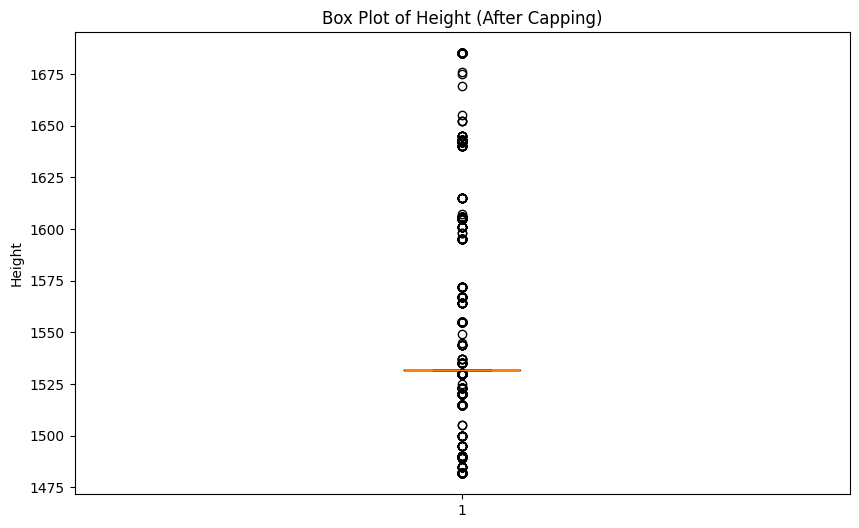

Outliers found in Wheel Base:
Outlier count in Wheel Base: 153

Capping applied to Wheel Base:
Lower bound: 2380.0, Upper bound: 2650.0
count    8369.000000
mean     2453.206954
std        28.099615
min      2380.000000
25%      2450.000000
50%      2450.000000
75%      2450.000000
max      2650.000000
Name: Wheel Base, dtype: float64


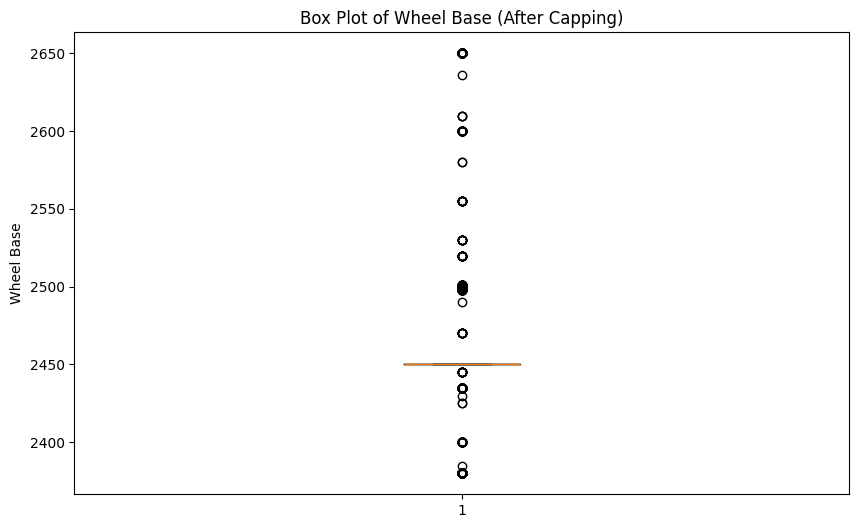

Outliers found in Kerb Weight:
Outlier count in Kerb Weight: 160

Capping applied to Kerb Weight:
Lower bound: 730.0, Upper bound: 2045.0
count    8369.000000
mean     1221.595412
std       219.229204
min       730.000000
25%      1200.000000
50%      1200.000000
75%      1200.000000
max      2045.000000
Name: Kerb Weight, dtype: float64


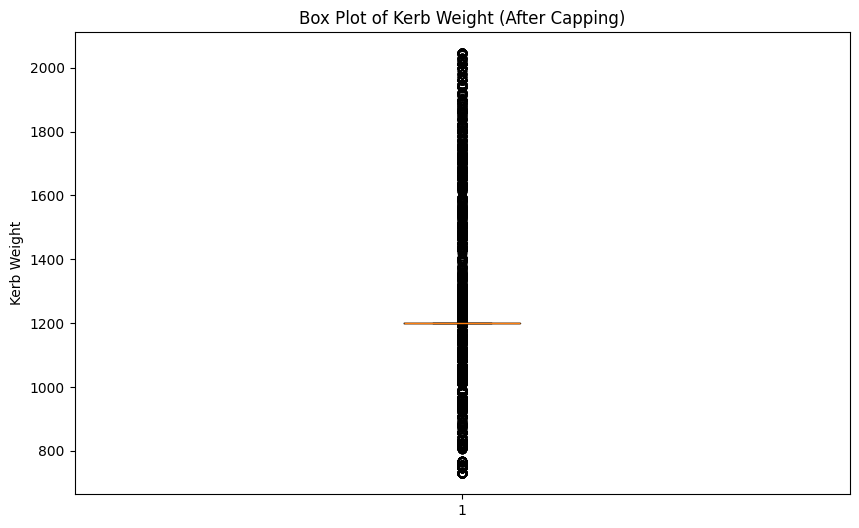

Outliers found in Gear Box:
Outlier count in Gear Box: 9

Capping applied to Gear Box:
Lower bound: 5.0, Upper bound: 5.0
count    8369.0
mean        5.0
std         0.0
min         5.0
25%         5.0
50%         5.0
75%         5.0
max         5.0
Name: Gear Box, dtype: float64


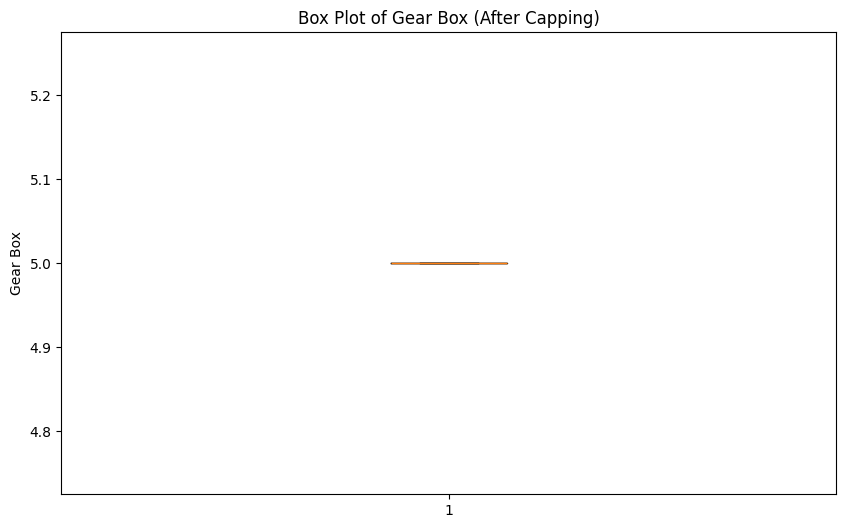

No outliers found in Drive Type.

Outliers found in Seating Capacity:
Outlier count in Seating Capacity: 85

Capping applied to Seating Capacity:
Lower bound: 4.0, Upper bound: 7.0
count    8369.000000
mean        5.192974
std         0.610158
min         4.000000
25%         5.000000
50%         5.000000
75%         5.000000
max         7.000000
Name: Seating Capacity, dtype: float64


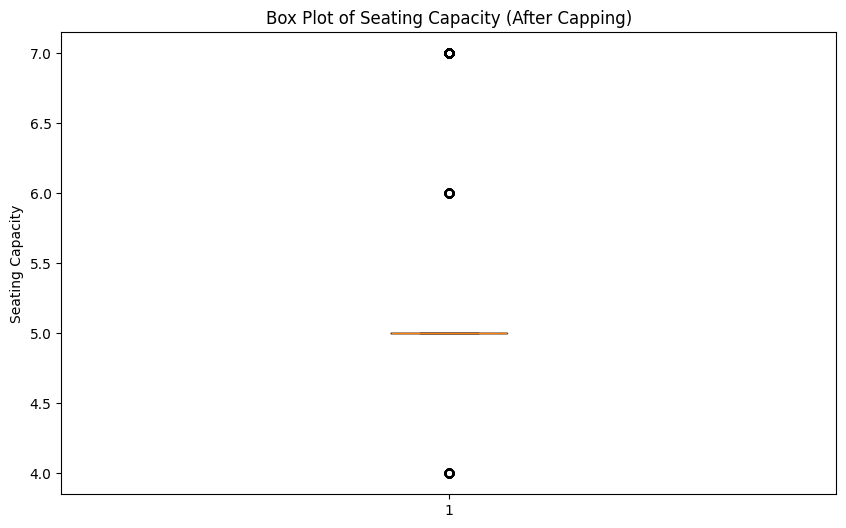

No outliers found in Front Brake Type.

No outliers found in Rear Brake Type.

No outliers found in Tyre Type.

Outliers found in Alloy Wheel Size:
Outlier count in Alloy Wheel Size: 50

Capping applied to Alloy Wheel Size:
Lower bound: 12.0, Upper bound: 19.0
count    8369.000000
mean       15.790656
std         1.183520
min        12.000000
25%        15.000000
50%        16.000000
75%        16.000000
max        19.000000
Name: Alloy Wheel Size, dtype: float64


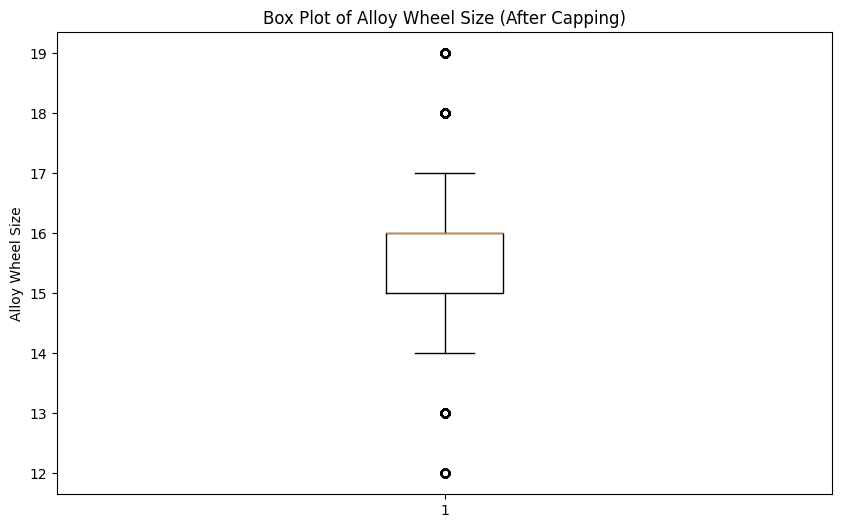

Outliers found in No Door Numbers:
Outlier count in No Door Numbers: 59

Capping applied to No Door Numbers:
Lower bound: 4.0, Upper bound: 5.0
count    8369.000000
mean        4.694587
std         0.460610
min         4.000000
25%         4.000000
50%         5.000000
75%         5.000000
max         5.000000
Name: No Door Numbers, dtype: float64


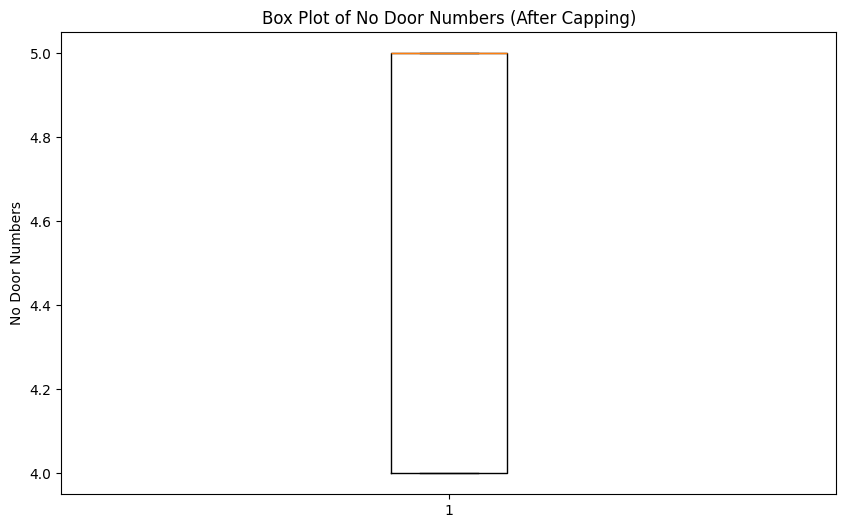

Outliers found in Cargo Volumn:
Outlier count in Cargo Volumn: 112

Capping applied to Cargo Volumn:
Lower bound: 177.0, Upper bound: 587.0
count    8369.000000
mean      350.693034
std        55.707052
min       177.000000
25%       350.000000
50%       350.000000
75%       350.000000
max       587.000000
Name: Cargo Volumn, dtype: float64


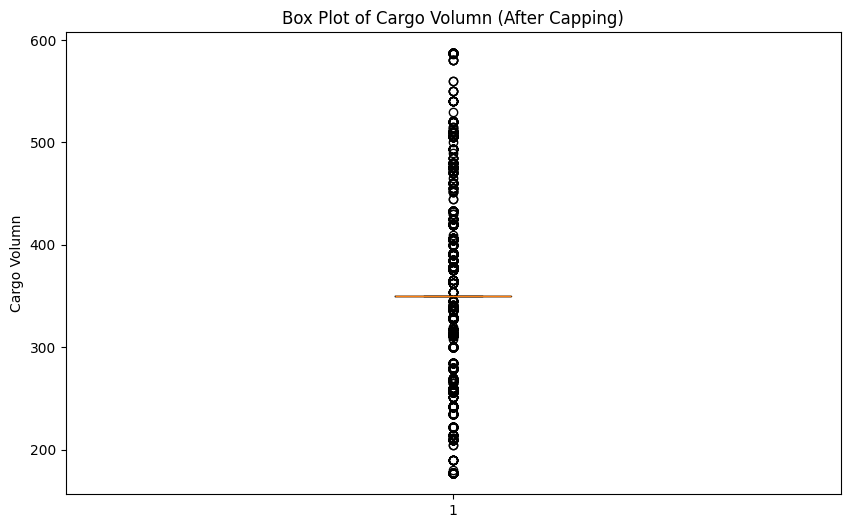

No outliers found in Mileage.

No outliers found in Value Configuration.

Outliers found in Compression Ratio:
Outlier count in Compression Ratio: 12

Capping applied to Compression Ratio:
Lower bound: 10.1, Upper bound: 10.1
count    8.369000e+03
mean     1.010000e+01
std      1.776463e-15
min      1.010000e+01
25%      1.010000e+01
50%      1.010000e+01
75%      1.010000e+01
max      1.010000e+01
Name: Compression Ratio, dtype: float64


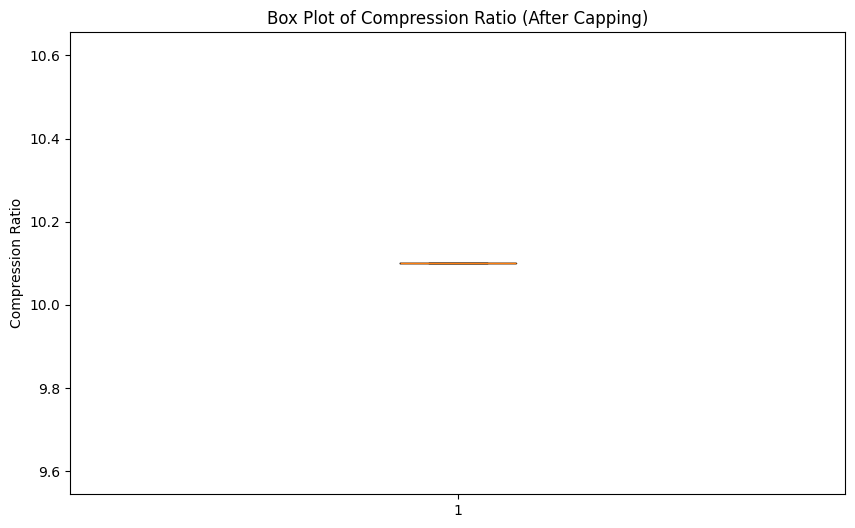

No outliers found in Super Charger.

Outliers found in Front Tread:
Outlier count in Front Tread: 136

Capping applied to Front Tread:
Lower bound: 1316.0, Upper bound: 1531.0
count    8369.000000
mean     1523.505676
std        24.873730
min      1316.000000
25%      1527.000000
50%      1527.000000
75%      1527.000000
max      1531.000000
Name: Front Tread, dtype: float64


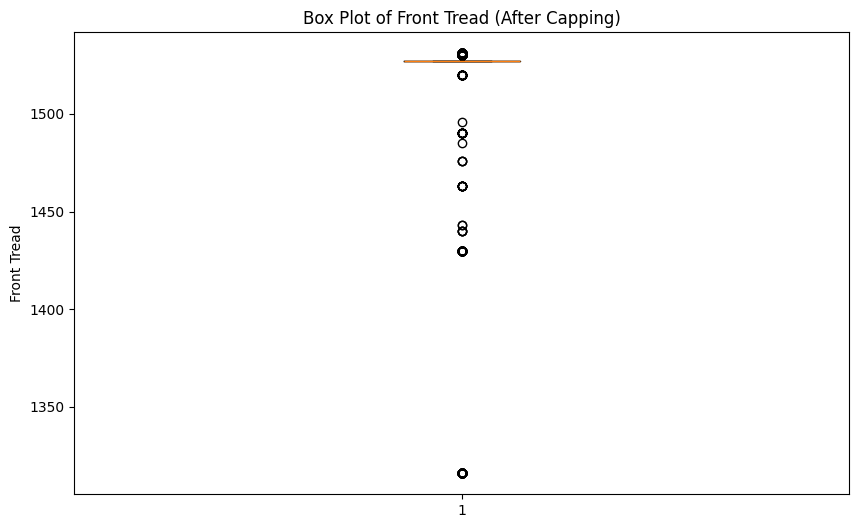

Outliers found in Rear Tread:
Outlier count in Rear Tread: 136

Capping applied to Rear Tread:
Lower bound: 1318.0, Upper bound: 1530.0
count    8369.000000
mean     1516.930338
std        23.589407
min      1318.000000
25%      1520.000000
50%      1520.000000
75%      1520.000000
max      1530.000000
Name: Rear Tread, dtype: float64


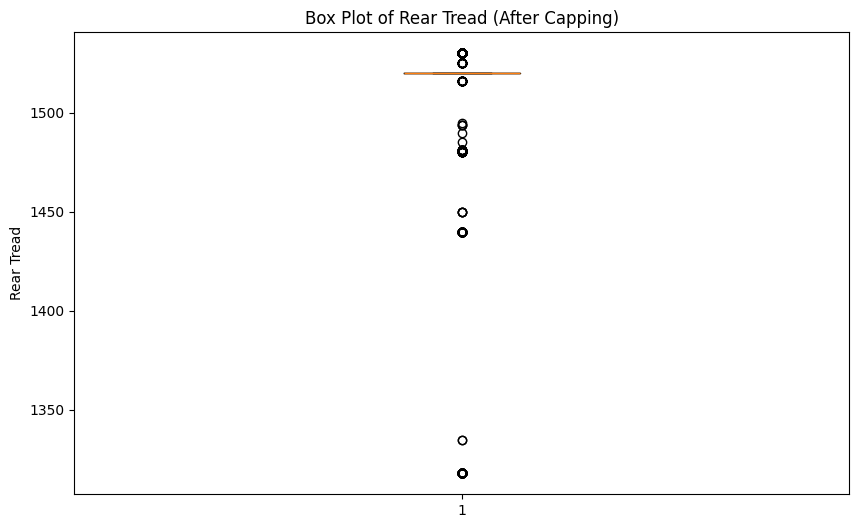

Outliers found in Gross Weight:
Outlier count in Gross Weight: 132

Capping applied to Gross Weight:
Lower bound: 1185.0, Upper bound: 1640.0
count    8369.000000
mean     1337.761381
std        41.242600
min      1185.000000
25%      1335.000000
50%      1335.000000
75%      1335.000000
max      1640.000000
Name: Gross Weight, dtype: float64


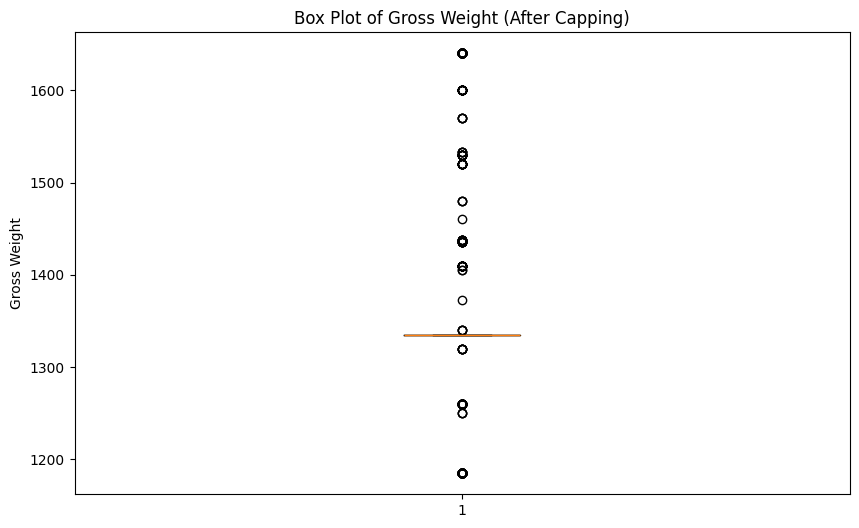

Outliers found in Turning Radius:
Outlier count in Turning Radius: 60

Capping applied to Turning Radius:
Lower bound: 4.5, Upper bound: 5.4
count    8369.000000
mean        4.905268
std         0.101200
min         4.500000
25%         4.900000
50%         4.900000
75%         4.900000
max         5.400000
Name: Turning Radius, dtype: float64


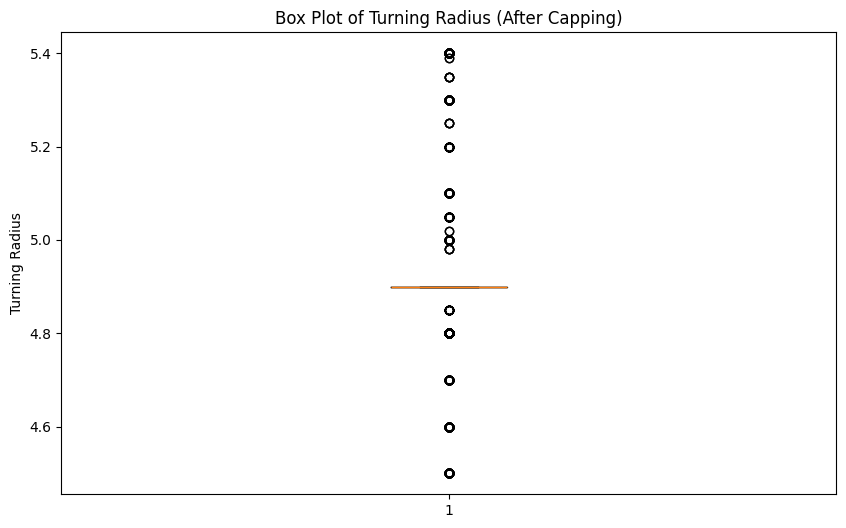

Outliers found in Top Speed:
Outlier count in Top Speed: 31

Capping applied to Top Speed:
Lower bound: 153.98, Upper bound: 153.98
count    8369.00
mean      153.98
std         0.00
min       153.98
25%       153.98
50%       153.98
75%       153.98
max       153.98
Name: Top Speed, dtype: float64


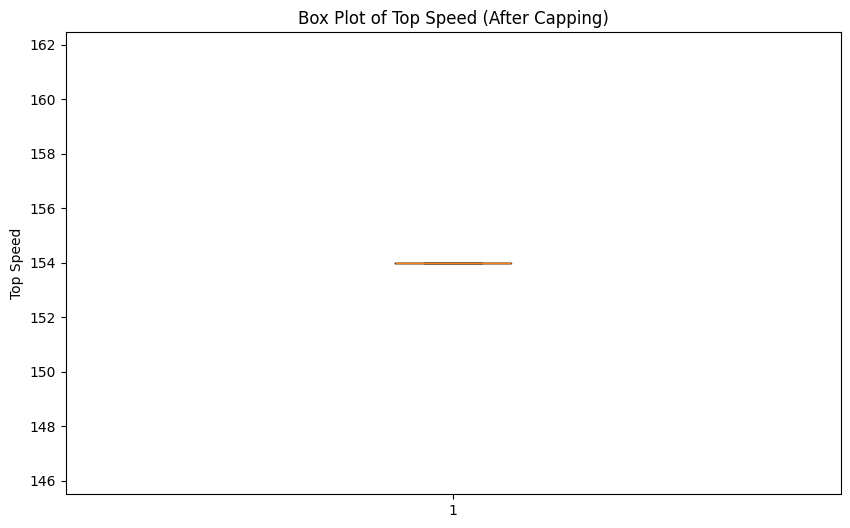

Outliers found in Acceleration:
Outlier count in Acceleration: 120

Capping applied to Acceleration:
Lower bound: 10.8, Upper bound: 10.8
count    8.369000e+03
mean     1.080000e+01
std      1.776463e-15
min      1.080000e+01
25%      1.080000e+01
50%      1.080000e+01
75%      1.080000e+01
max      1.080000e+01
Name: Acceleration, dtype: float64


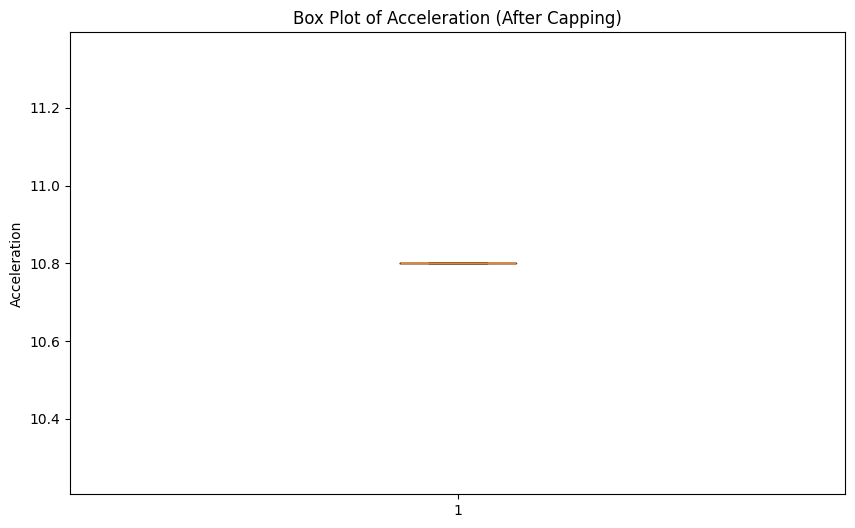

No outliers found in BoreX Stroke.

Outliers found in Ground Clearance Unladen:
Outlier count in Ground Clearance Unladen: 25

Capping applied to Ground Clearance Unladen:
Lower bound: 160.0, Upper bound: 160.0
count    8369.0
mean      160.0
std         0.0
min       160.0
25%       160.0
50%       160.0
75%       160.0
max       160.0
Name: Ground Clearance Unladen, dtype: float64


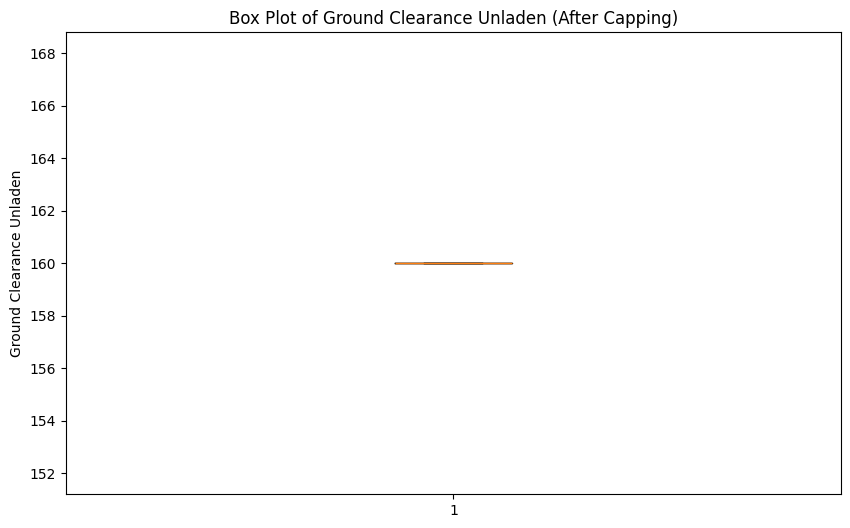

In [136]:
import pandas as pd
import matplotlib.pyplot as plt

def find_and_cap_numerical_outliers(df, lower_percentile=0.01, upper_percentile=0.99):
    """
    Finds outliers in all numerical columns using percentiles,
    caps if found, and visualizes the results.
    """

    numerical_cols = df.select_dtypes(include=['number']).columns.tolist()  # Convert to list

    for column in numerical_cols:
        lower_bound = df[column].quantile(lower_percentile)
        upper_bound = df[column].quantile(upper_percentile)

        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]

        if not outliers.empty:
            print(f"Outliers found in {column}:")
            print(f"Outlier count in {column}: {len(outliers)}\n")

            # Cap using specified percentiles
            df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)

            print(f"Capping applied to {column}:")
            print(f"Lower bound: {lower_bound}, Upper bound: {upper_bound}")
            print(df[column].describe())

            plt.figure(figsize=(10, 6))
            plt.boxplot(df[column])
            plt.title(f'Box Plot of {column} (After Capping)')
            plt.ylabel(column)
            plt.show()

        else:
            print(f"No outliers found in {column}.\n")

# Example Usage:
# Assuming 'df' is your DataFrame
find_and_cap_numerical_outliers(df)

<Figure size 1500x800 with 0 Axes>

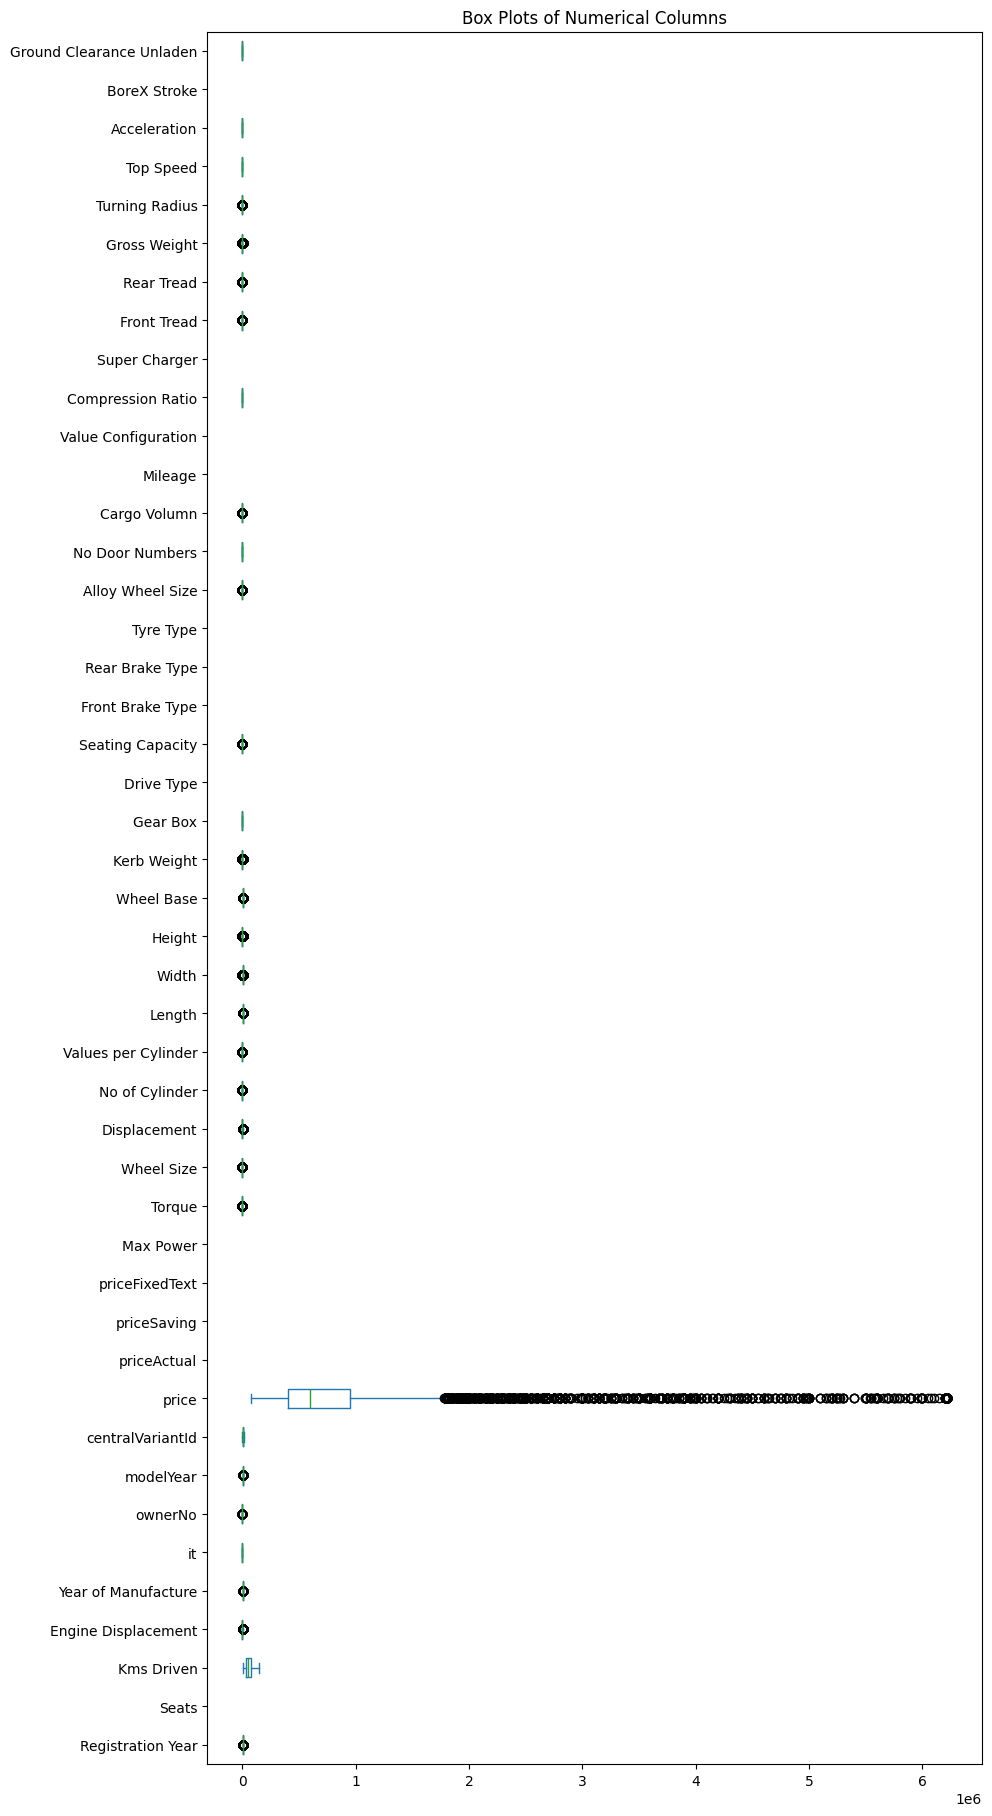

In [137]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming 'df' is your Pandas DataFrame

# Get all numerical columns
numerical_cols = df.select_dtypes(include=['number']).columns

# Create box plots for each numerical column
plt.figure(figsize=(15, 8))  # Adjust figure size for better readability
df[numerical_cols].plot(kind='box', vert=False, figsize=(10, len(numerical_cols) * 0.5))
plt.title("Box Plots of Numerical Columns")
plt.show()

In [138]:
# Saving the updated data
df.to_csv('final_cleaned_data.csv', index=False)

In [5]:
import pandas as pd

# Load the dataset
df = pd.read_csv(r'D:\Data Science\Python.VS\sownd\project 3 cardekho\final_cleaned_data.csv')

# Calculate summary statistics
mean_price = df['price'].mean()
median_price = df['price'].median()
mode_price = df['price'].mode()[0]
std_dev_price = df['price'].std()

print(f"Mean Price: {mean_price:.2f}")
print(f"Median Price: {median_price:.2f}")
print(f"Mode Price: {mode_price:.2f}")
print(f"Standard Deviation of Price: {std_dev_price:.2f}")


Mean Price: 918927.24
Median Price: 601000.00
Mode Price: 650000.00
Standard Deviation of Price: 1029587.03


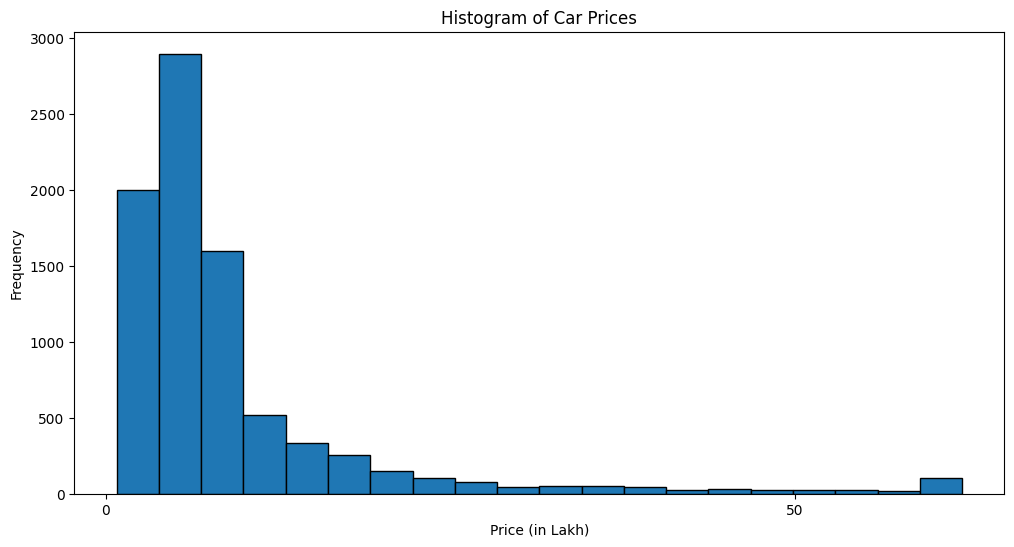

In [141]:
import matplotlib.pyplot as plt

# Convert price to lakhs
df['price_lakh'] = df['price'] / 1e5

# Plot the histogram
plt.figure(figsize=(12, 6))
plt.hist(df['price_lakh'], bins=20, edgecolor='k')
plt.title('Histogram of Car Prices')
plt.xlabel('Price (in Lakh)')
plt.ylabel('Frequency')
plt.xticks(range(0, int(df['price_lakh'].max()) + 20, 50))  # Setting the x-axis range to be in lakhs with intervals of 5 Lakh
plt.show()


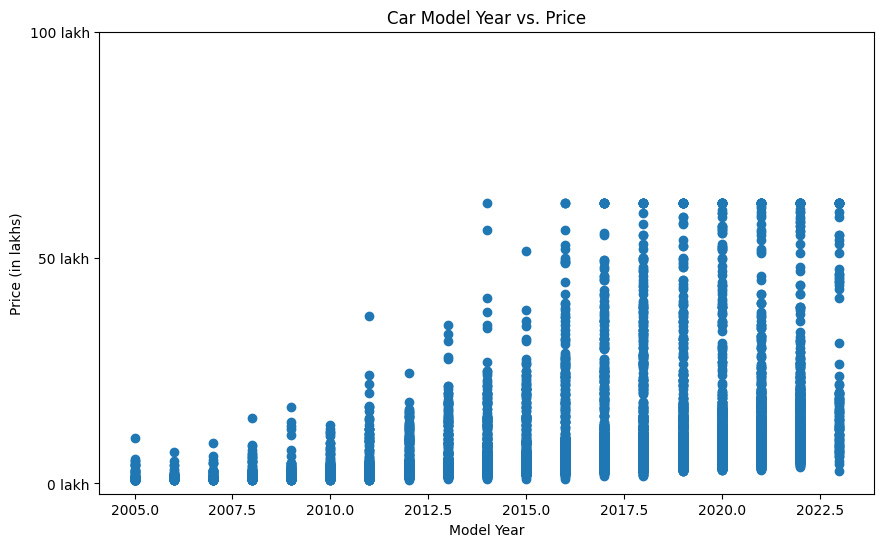

In [142]:
# Scatter Plot
plt.figure(figsize=(10, 6))
plt.scatter(df['modelYear'], df['price'])
plt.title('Car Model Year vs. Price')
plt.xlabel('Model Year')
plt.ylabel('Price (in lakhs)')

# Set the y-axis ticks and labels to intervals of 10 lakh
max_price = int(df['price'].max())  # Convert max price to integer
y_ticks = range(0, max_price + 5_000_000, 5_000_000)  # Intervals of 50 lakh
y_labels = [f'{i//1_00_000} lakh' for i in y_ticks]  # Format as 'x lakh'
plt.yticks(y_ticks, y_labels)

plt.show()


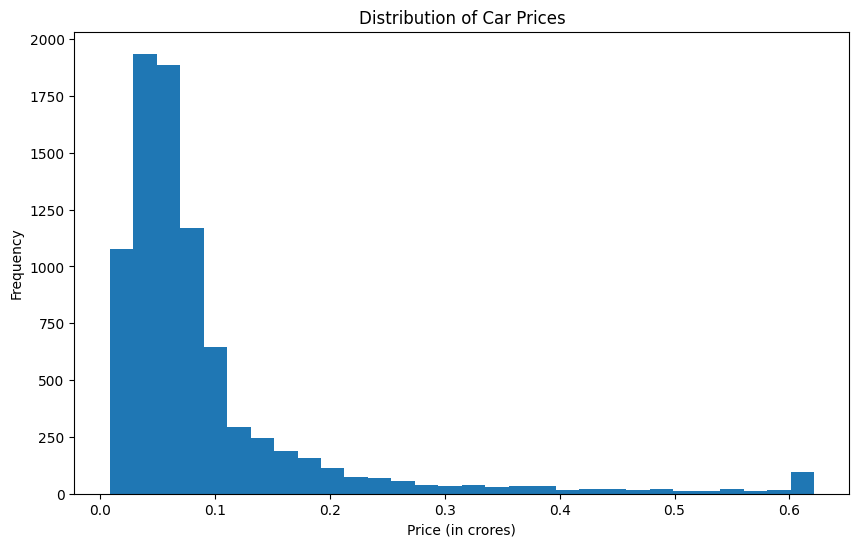

In [143]:
plt.figure(figsize=(10, 6))
plt.hist(df['price'] / 100_00_000, bins=30)  # Convert price to crores
plt.title('Distribution of Car Prices')
plt.xlabel('Price (in crores)')
plt.ylabel('Frequency')
plt.show()

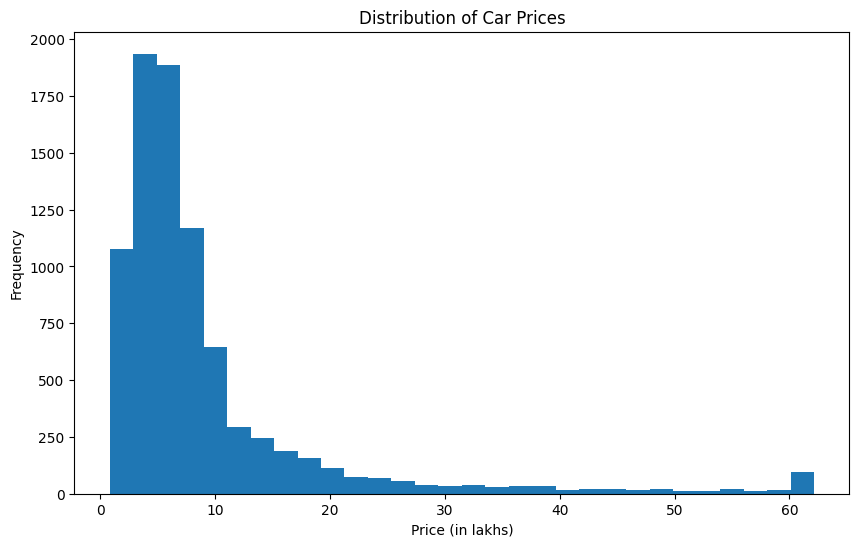

In [144]:
# Histogram with price in lakhs
plt.figure(figsize=(10, 6))
plt.hist(df['price'] / 100_000, bins=30)  # Convert price to lakhs
plt.title('Distribution of Car Prices')
plt.xlabel('Price (in lakhs)')
plt.ylabel('Frequency')
plt.show()

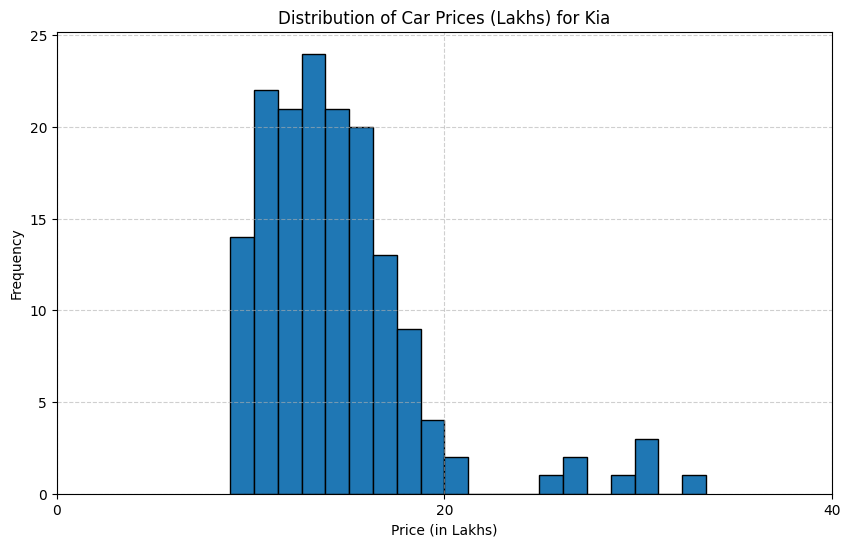

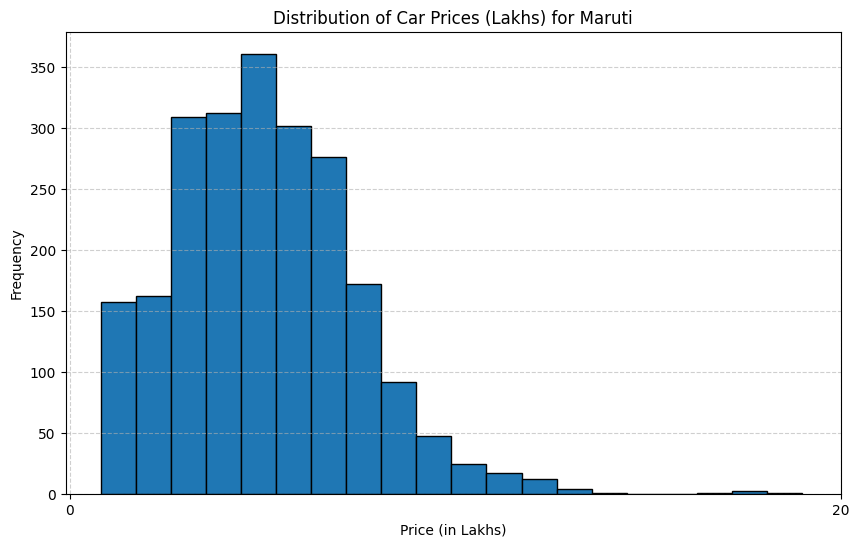

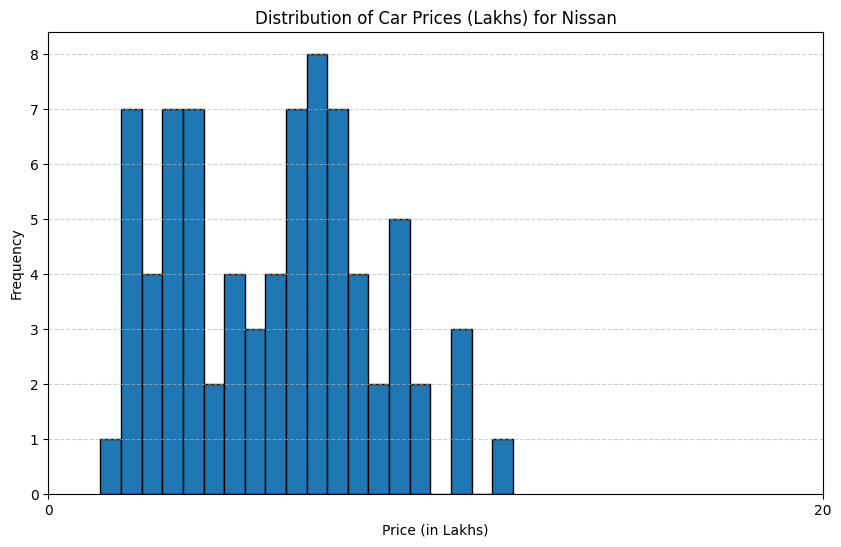

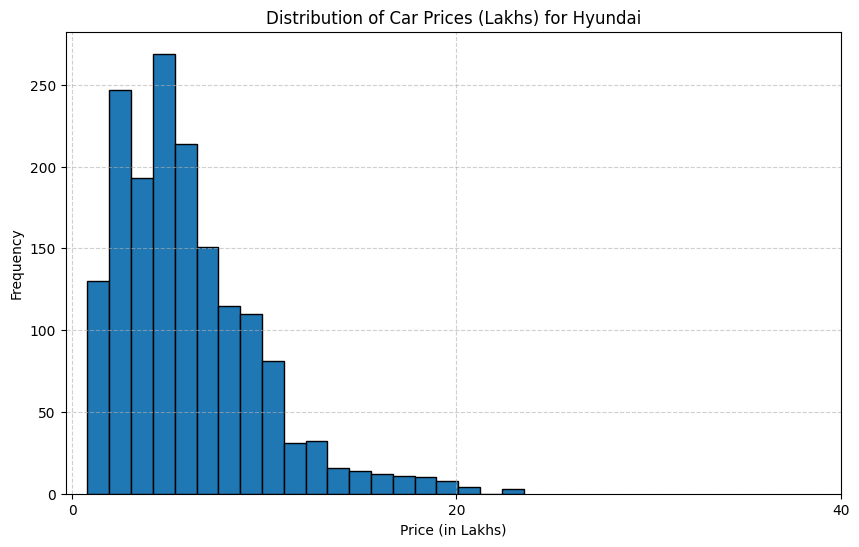

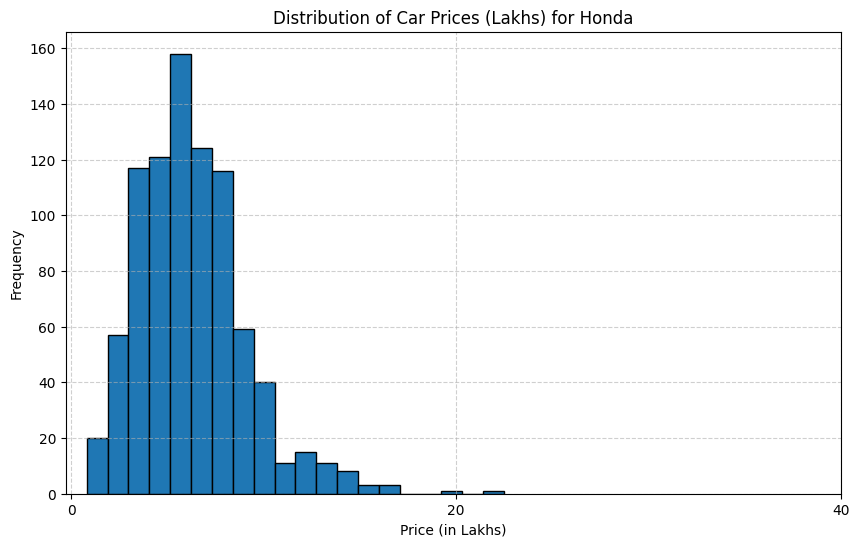

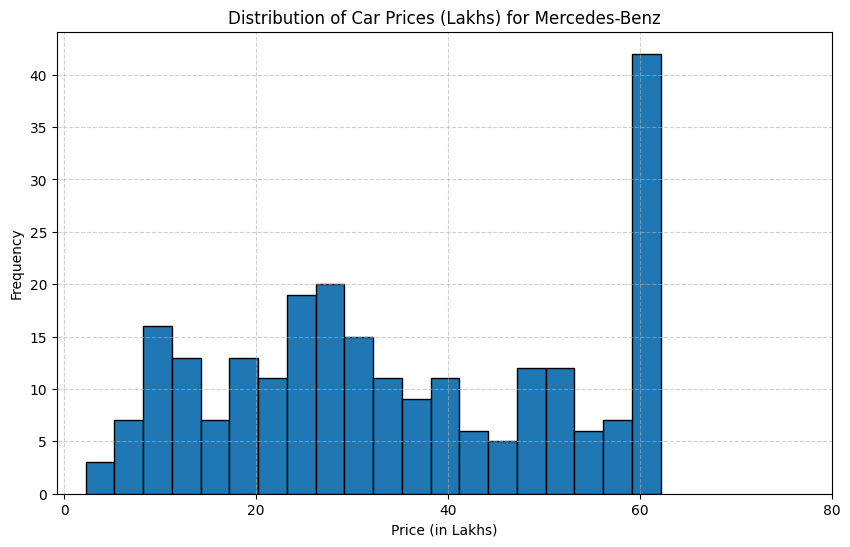

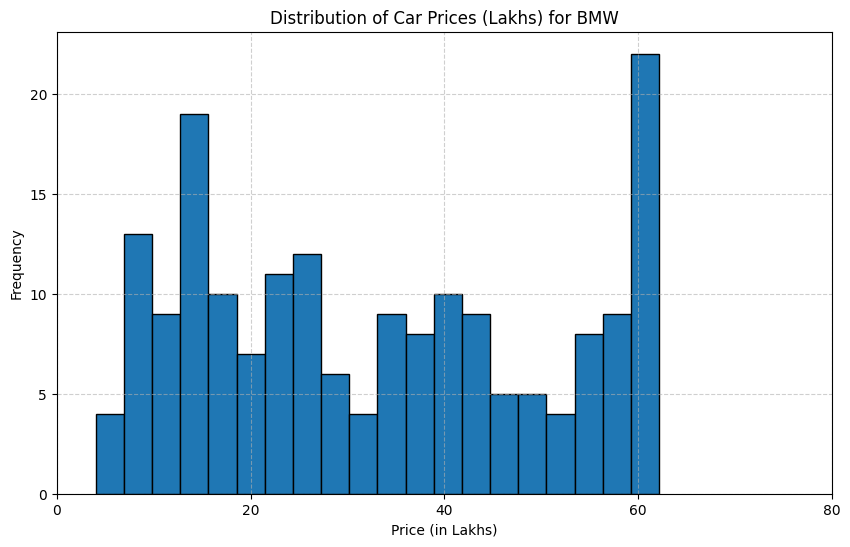

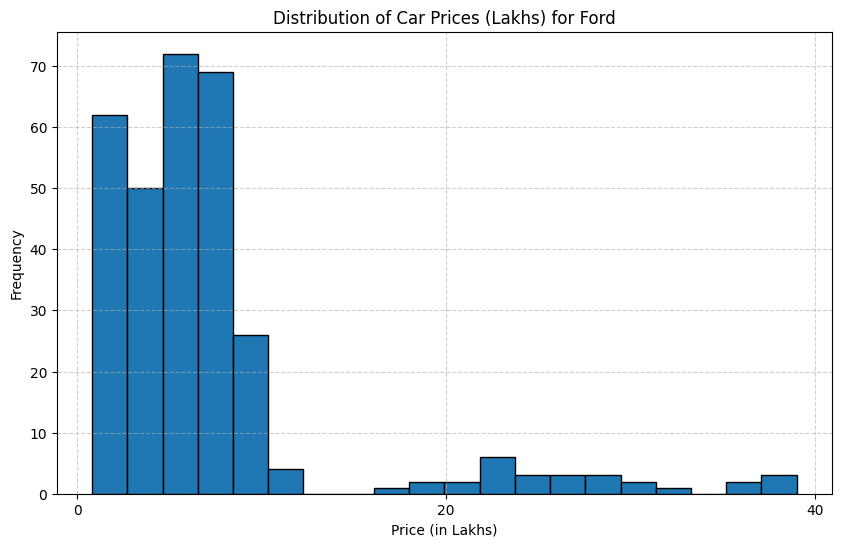

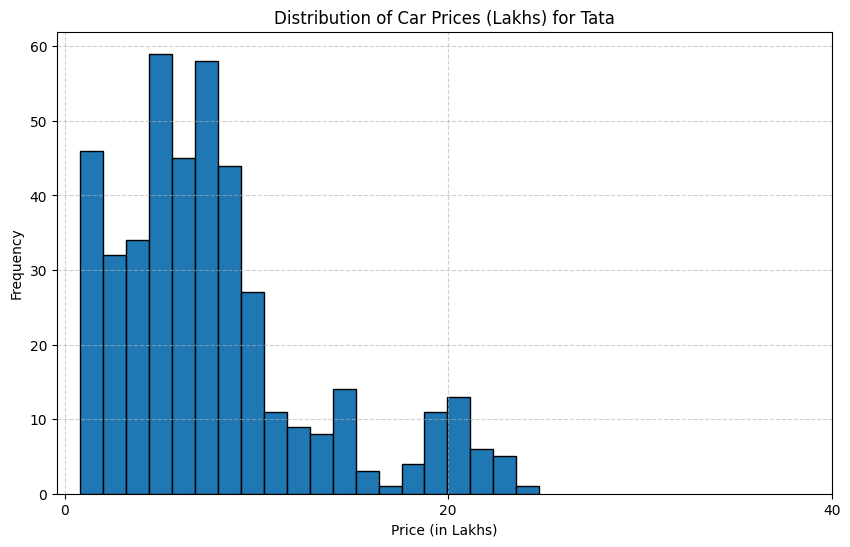

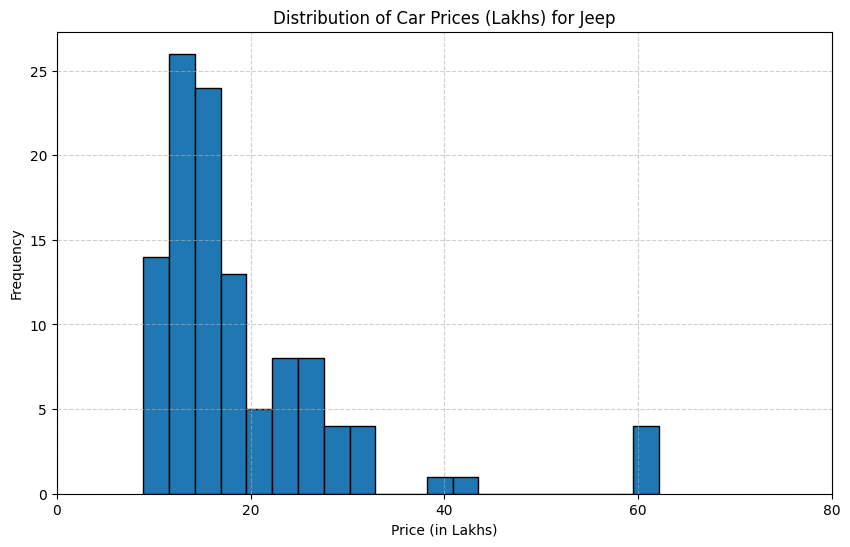

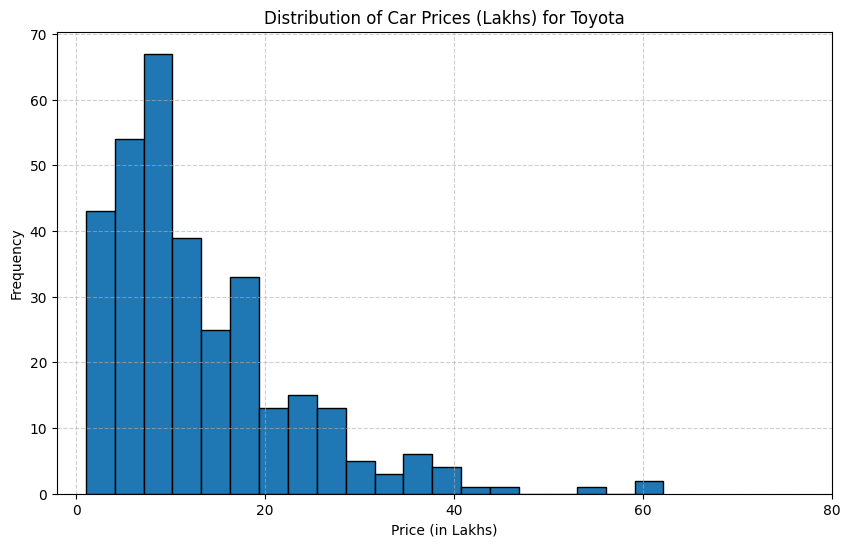

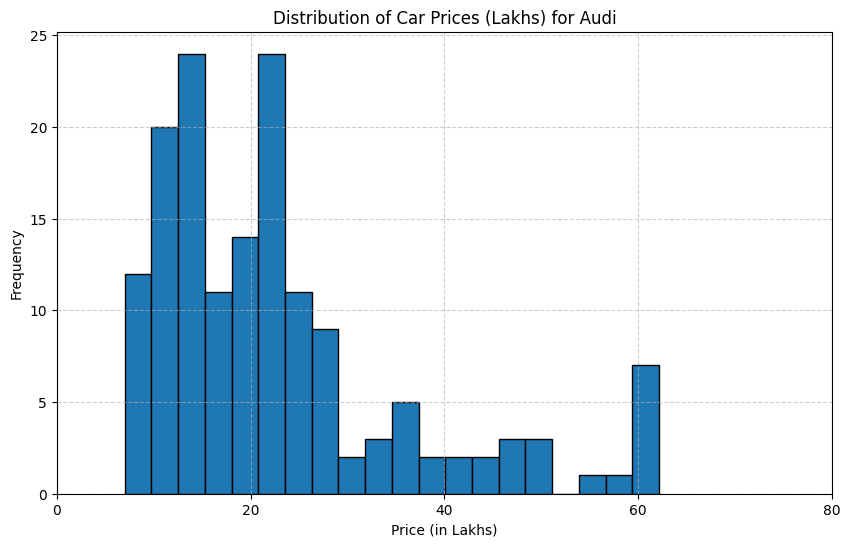

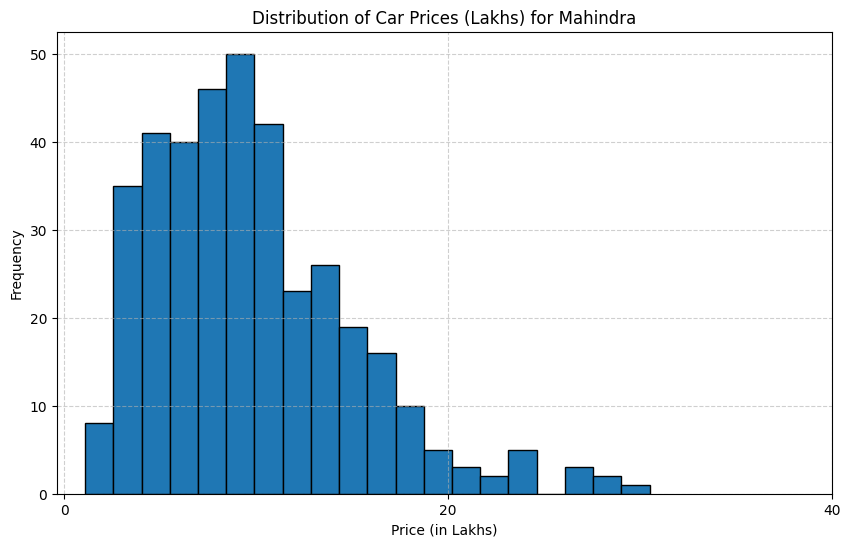

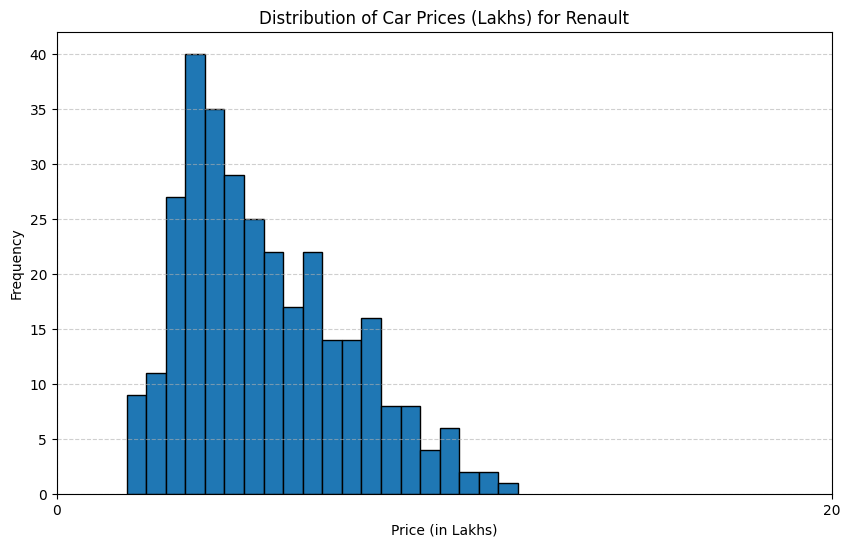

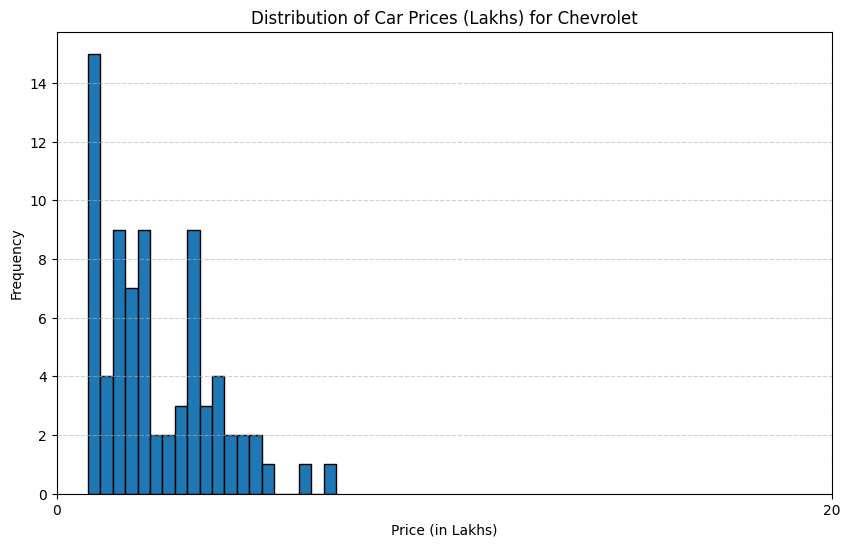

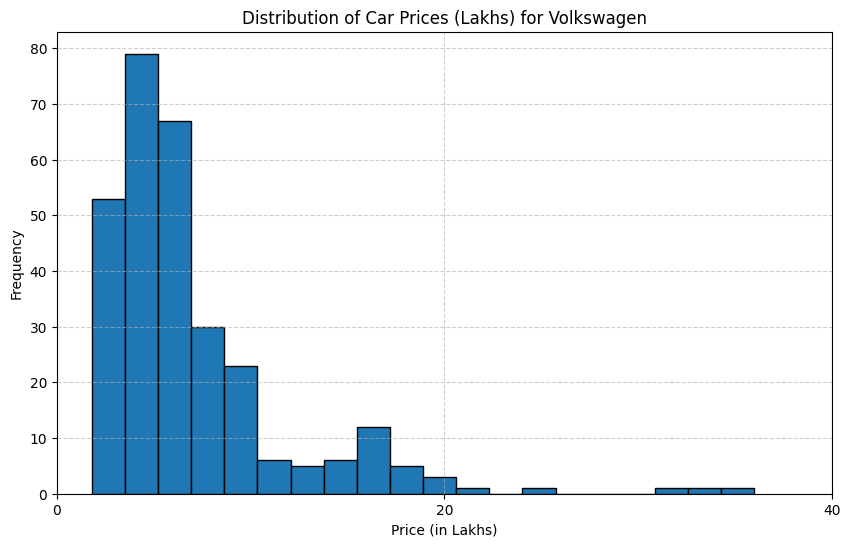

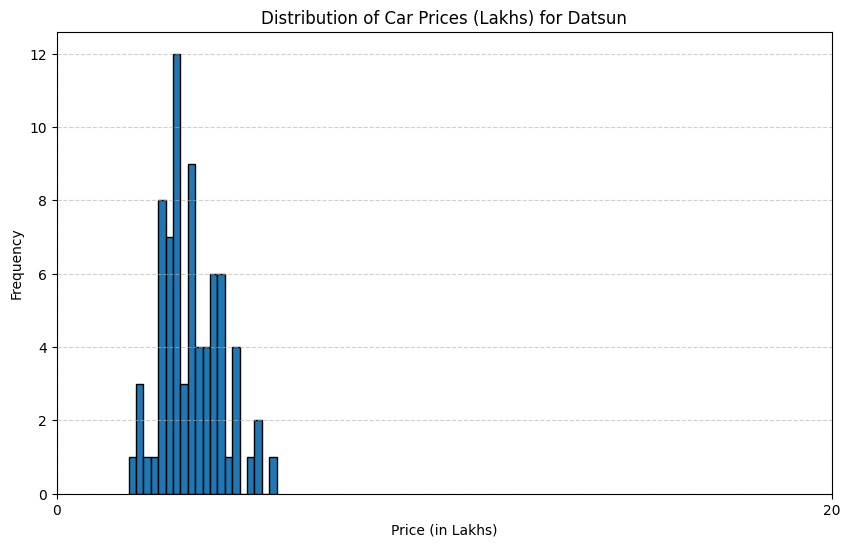

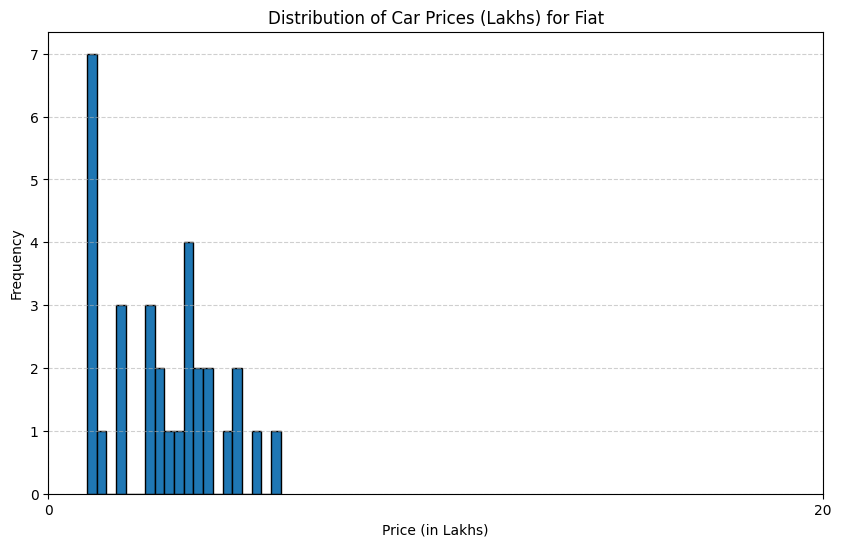

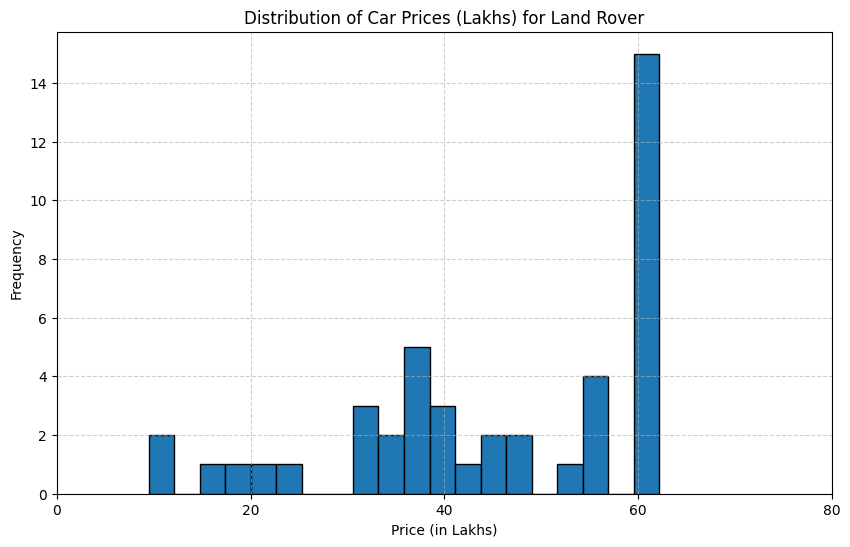

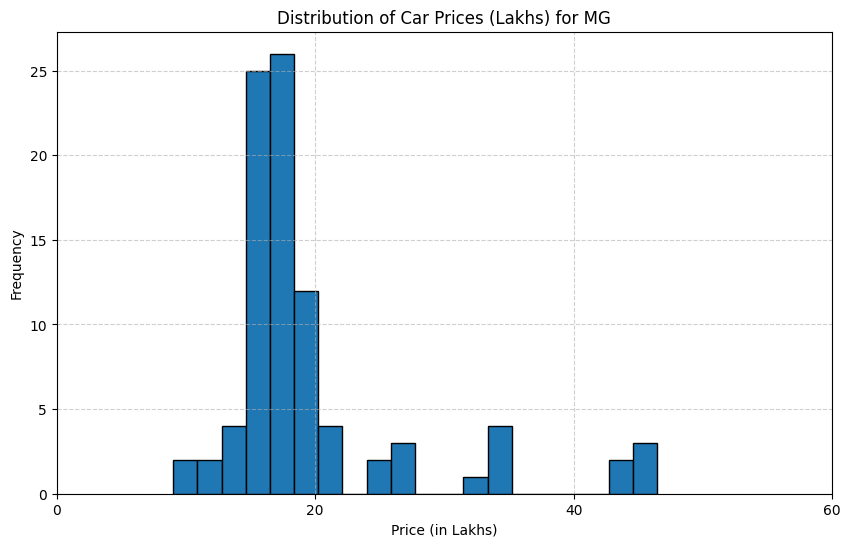

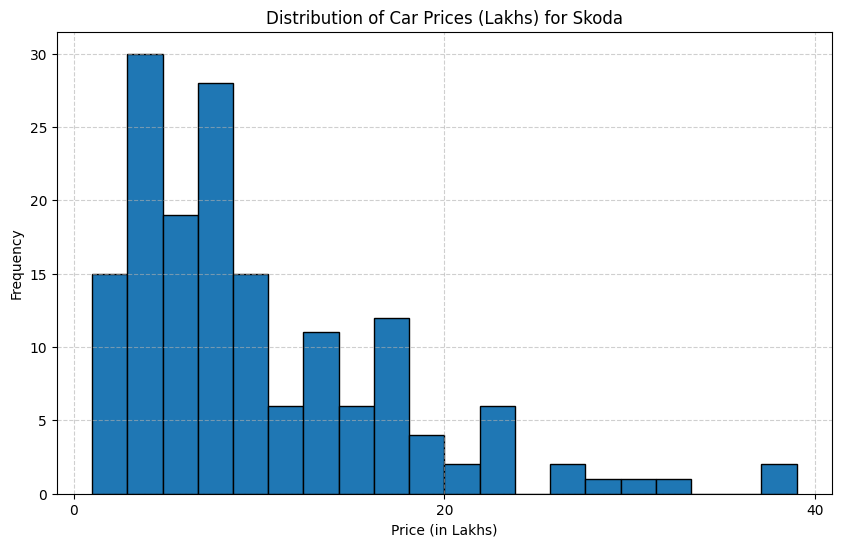

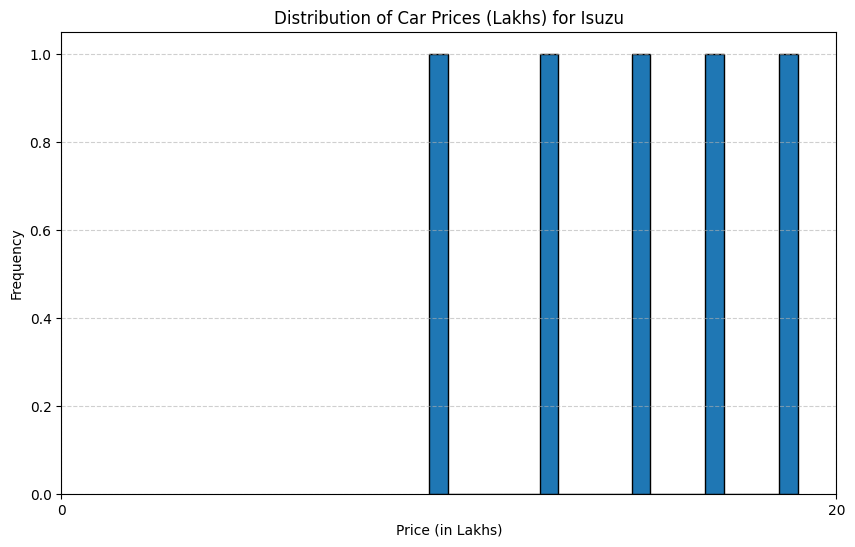

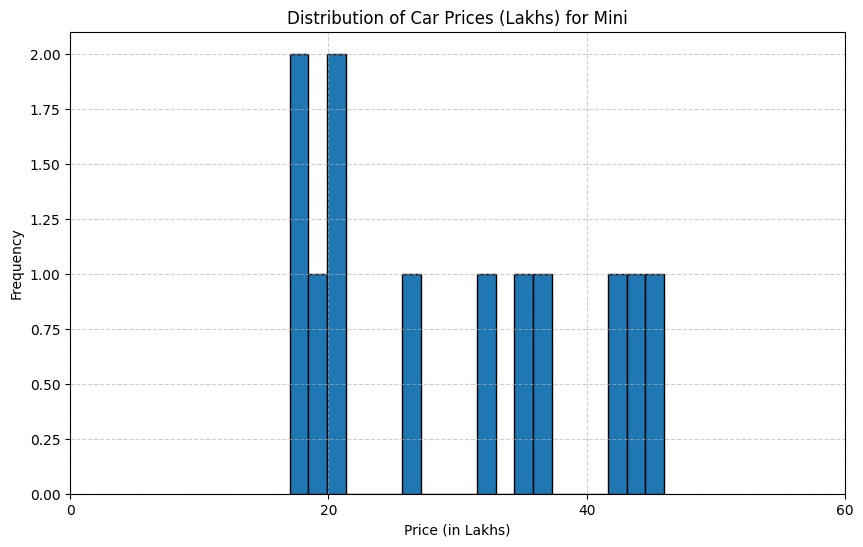

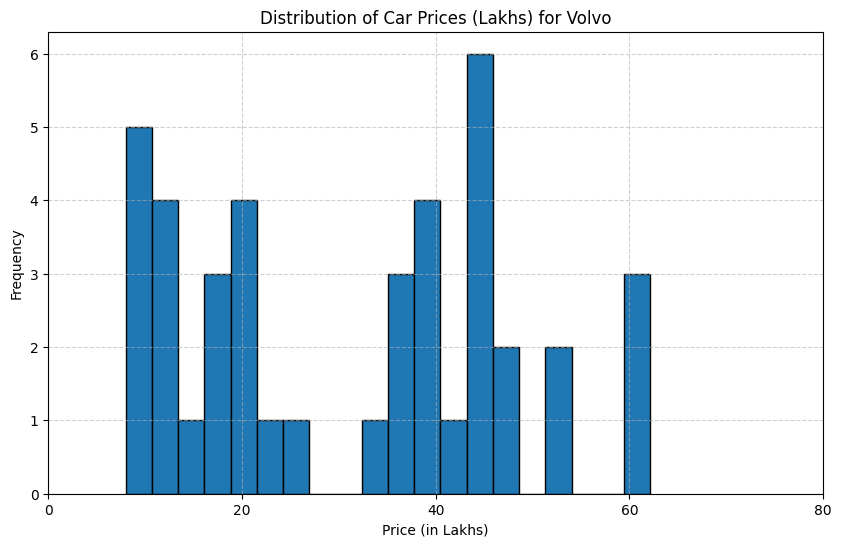

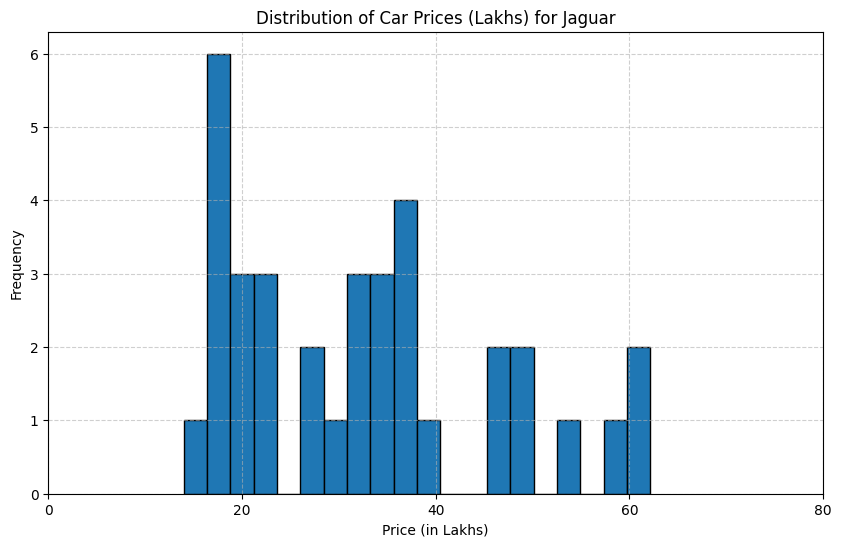

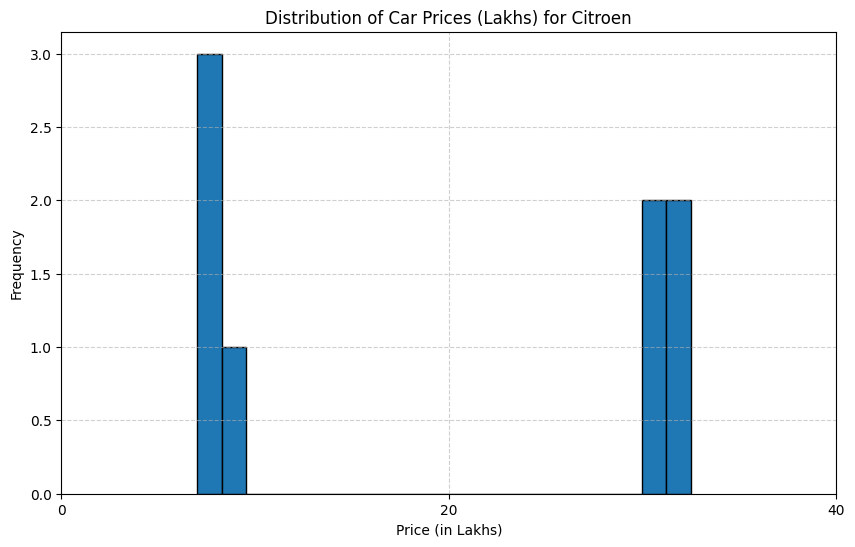

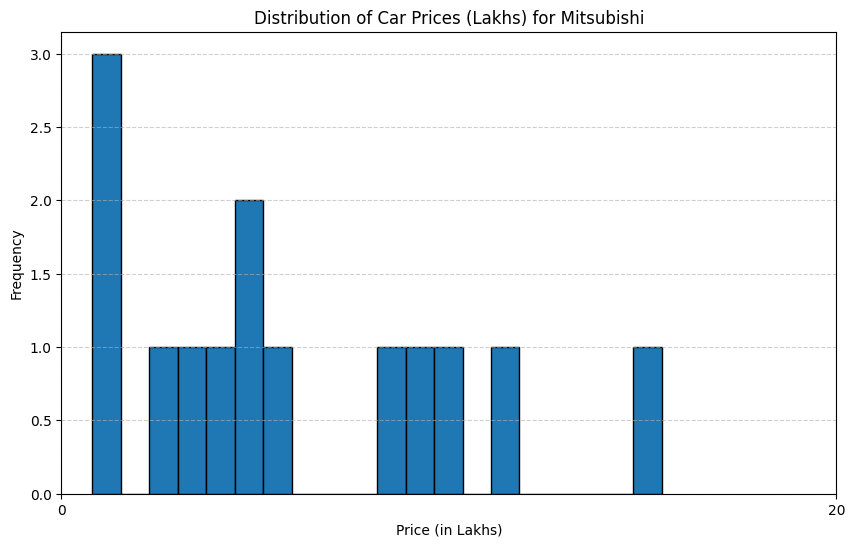

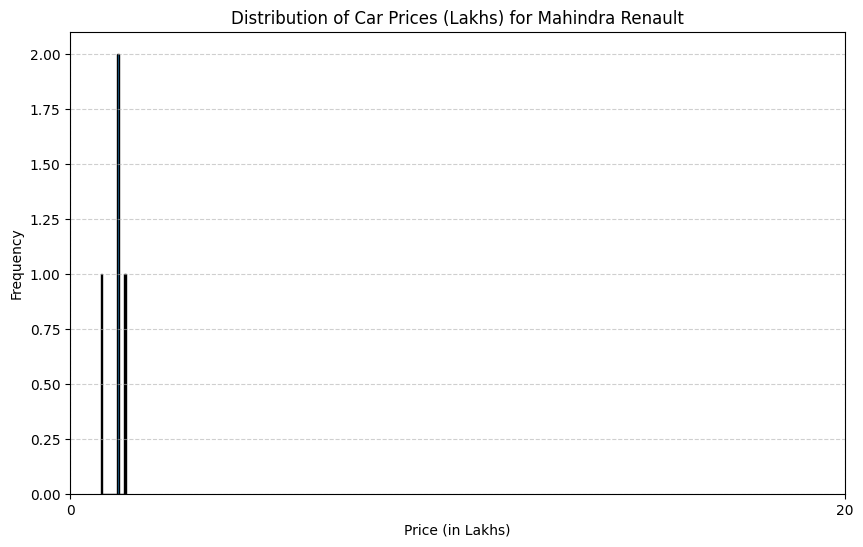

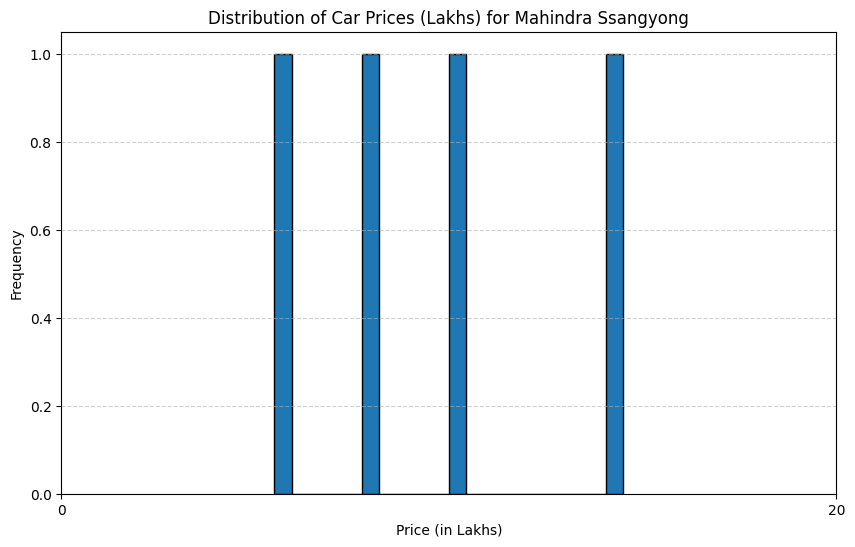

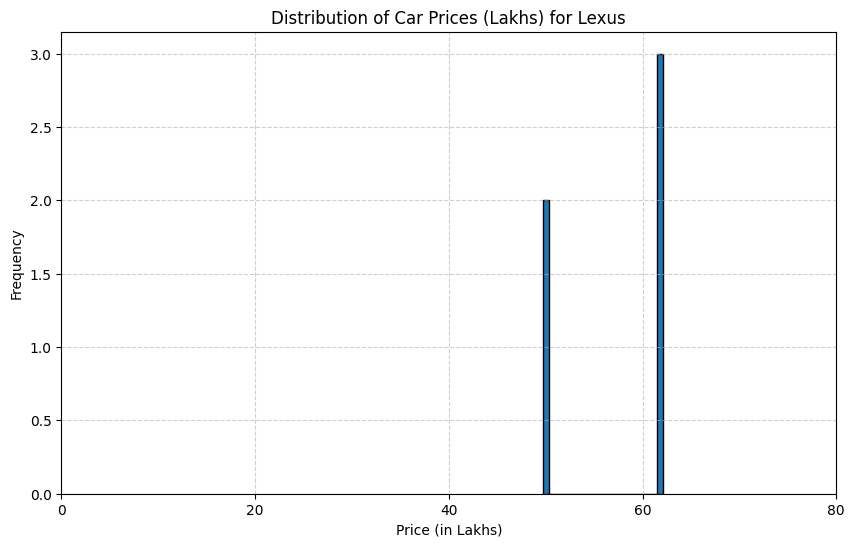

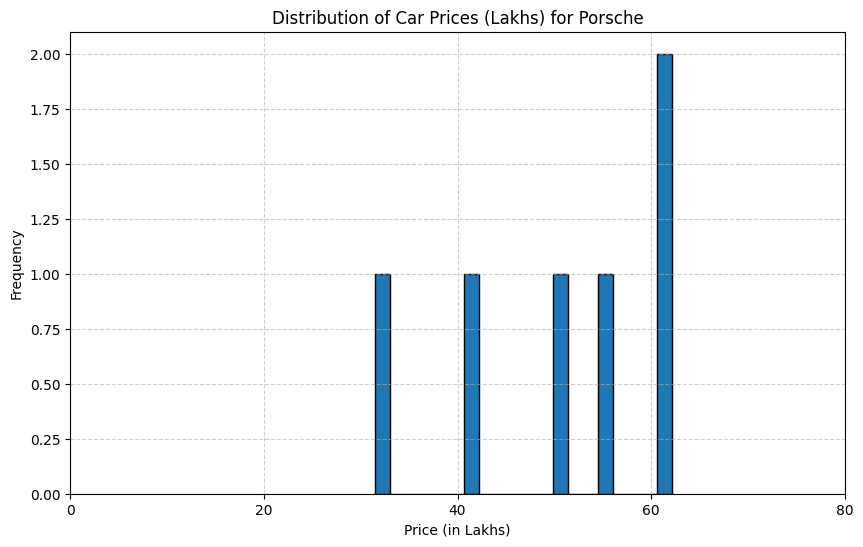

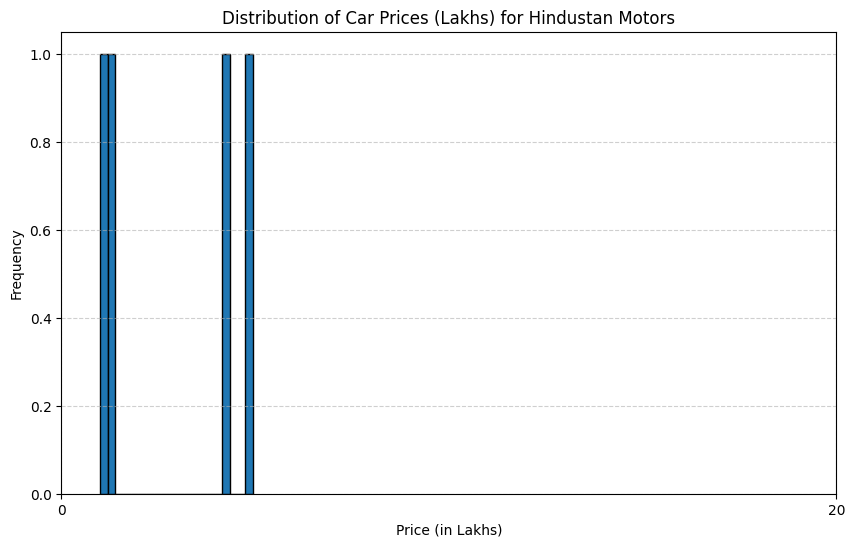

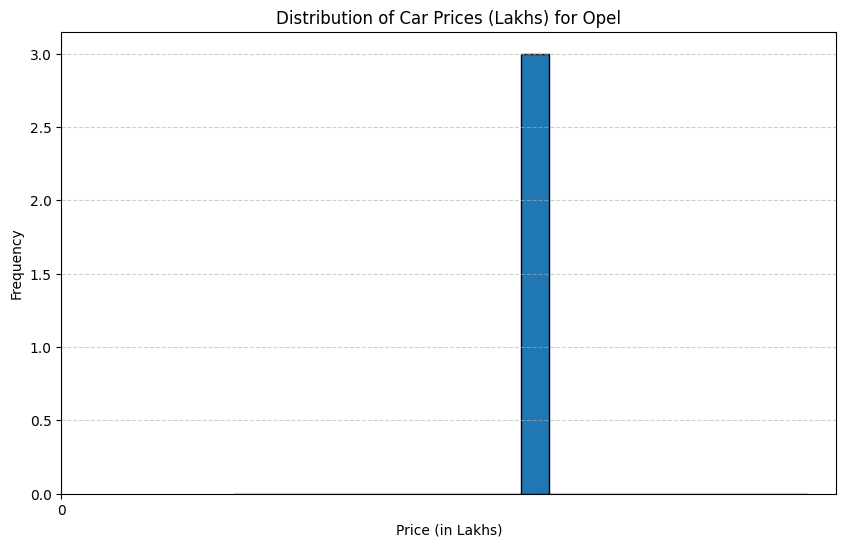

In [151]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  # Import seaborn for nicer plots (optional)

# Assuming 'df' is your DataFrame

for oem in df['oem'].unique():
    oem_df = df[df['oem'] == oem]
    plt.figure(figsize=(10, 6))
    prices_lakhs = oem_df['price'] / 100_000  # Convert prices to lakhs
    plt.hist(prices_lakhs, bins=20, edgecolor='black')
    plt.title(f'Distribution of Car Prices (Lakhs) for {oem}')
    plt.xlabel('Price (in Lakhs)')
    plt.ylabel('Frequency')
    plt.grid(True, linestyle='--', alpha=0.6)

    # Set x-axis ticks and labels (intervals of 20 lakhs)
    max_price_lakhs = int(prices_lakhs.max())
    x_ticks = range(0, max_price_lakhs + 20, 20)
    plt.xticks(x_ticks)

    plt.show()

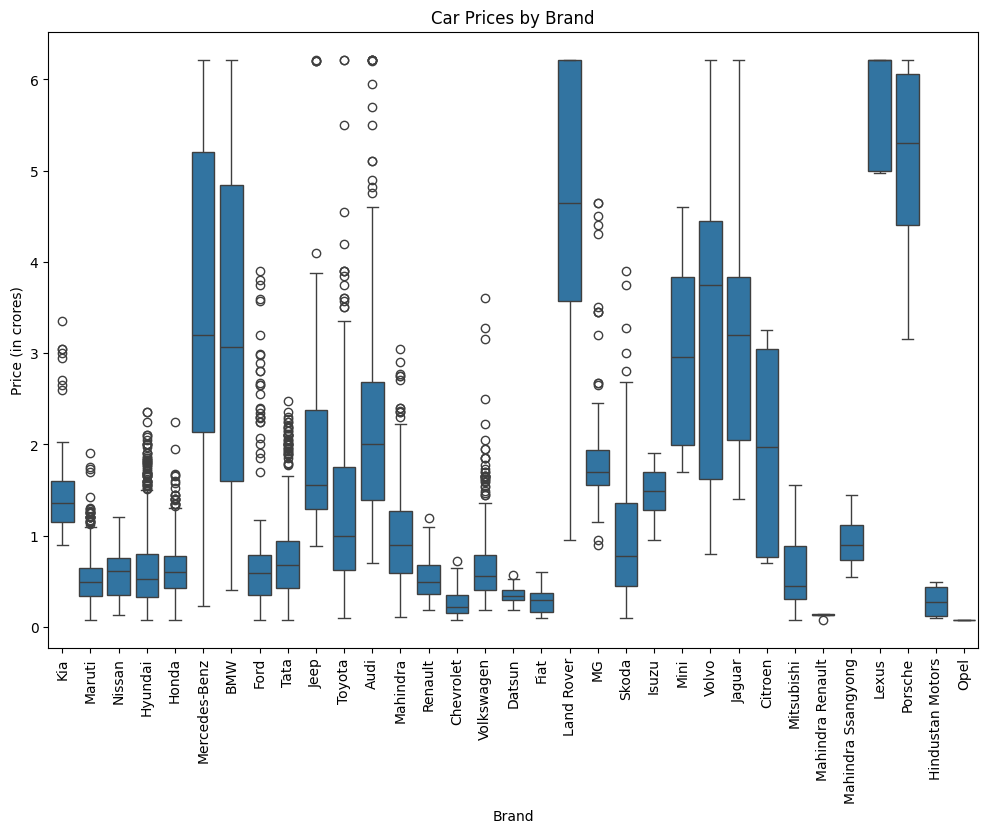

In [153]:
# Box Plot with price in crores
plt.figure(figsize=(12, 8))
sns.boxplot(x='oem', y=df['price'] / 10_00_000, data=df)  # Convert price to crores
plt.title('Car Prices by Brand')
plt.xlabel('Brand')
plt.ylabel('Price (in crores)')
plt.xticks(rotation=90)
plt.show()

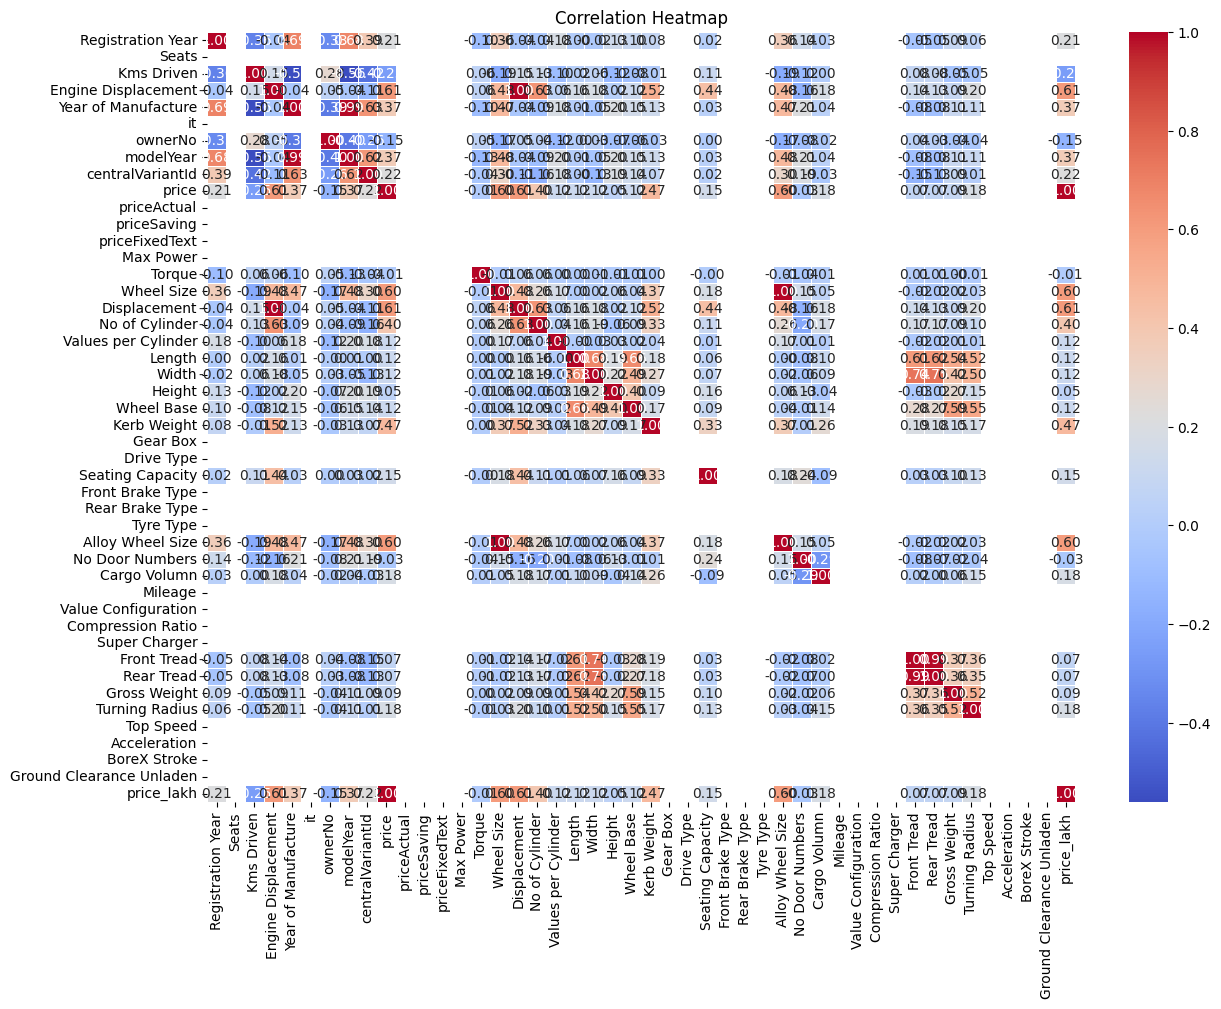

In [154]:
# Select only numeric columns (including price_log)
numeric_df = df.select_dtypes(include=[float, int])

# Correlation Heatmap (including price_log)
plt.figure(figsize=(14, 10))
heatmap = sns.heatmap(numeric_df.corr().round(2), annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()


In [156]:
# Select only numeric columns
numeric_df = df.select_dtypes(include=[float, int])

# Calculate correlation matrix
correlation_matrix = numeric_df.corr()

# Print the correlation of each feature with the 'price'
price_correlation = correlation_matrix['price'].sort_values(ascending=False)
print(price_correlation)

price                       1.000000
price_lakh                  1.000000
Engine Displacement         0.614785
Displacement                0.614771
Wheel Size                  0.604505
Alloy Wheel Size            0.604505
Kerb Weight                 0.467438
No of Cylinder              0.402300
modelYear                   0.374321
Year of Manufacture         0.374067
centralVariantId            0.219610
Registration Year           0.209452
Turning Radius              0.178454
Cargo Volumn                0.176720
Seating Capacity            0.146949
Wheel Base                  0.123451
Length                      0.122445
Width                       0.120879
Values per Cylinder         0.117707
Gross Weight                0.089173
Front Tread                 0.069933
Rear Tread                  0.065767
Height                      0.053382
Torque                     -0.008139
No Door Numbers            -0.025232
ownerNo                    -0.146878
Kms Driven                 -0.246415
S

In [9]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error
import pandas as pd
import numpy as np

features = ["Registration Year", "Year of Manufacture", "modelYear", "Kms Driven", "Top Speed", "Engine Displacement", "ownerNo", "Acceleration", "Insurance Validity", "Fuel Type", "Transmission", "Ownership", "oem", "model", "Color", "Seating Capacity"]
X = df[features]
y = df['price']


# 2. Remove Completely Empty Columns
cols_to_remove = ['Seats', 'priceActual', 'priceSaving', 'priceFixedText', 'Max Power',
                   'Drive Type', 'Front Brake Type', 'Rear Brake Type', 'Tyre Type', 'Mileage',
                   'Value Configuration', 'Super Charger', 'BoreX Stroke']

X_cleaned = X.drop(columns=cols_to_remove, errors='ignore')

# Handle categorical features using Label Encoding
encoders = {}
for col in X.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X.loc[:, col] = le.fit_transform(X[col]) # use .loc to prevent SettingWithCopyWarning
    encoders[col] = le

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)
X_imputed = pd.DataFrame(X_imputed, columns=X.columns)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

# Hyperparameter tuning (GridSearchCV) with cross-validation within
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10]
}

rf_grid_search = GridSearchCV(RandomForestRegressor(), rf_param_grid, cv=3, scoring='neg_mean_squared_error')
rf_grid_search.fit(X_train, y_train)
rf_model = rf_grid_search.best_estimator_

y_pred_rf = rf_model.predict(X_test)
rmse_rf = root_mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

cv_scores_rf = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
cv_rmse_scores_rf = np.sqrt(-cv_scores_rf)

print("Random Forest:")
print(f"  Test Set RMSE: {rmse_rf}")
print(f"  Test Set R-squared: {r2_rf}")
print(f"  Cross-Validation RMSE Scores: {cv_rmse_scores_rf}")
print(f"  Mean Cross-Validation RMSE: {cv_rmse_scores_rf.mean()}")
print(f"  Standard Deviation of Cross-Validation RMSE: {cv_rmse_scores_rf.std()}")
print(f"  Best parameters: {rf_grid_search.best_params_}")

Random Forest:
  Test Set RMSE: 310139.79847830837
  Test Set R-squared: 0.9158433097567324
  Cross-Validation RMSE Scores: [314815.88173314 311700.66201493 311511.16129541 336510.65631726
 313971.76106042]
  Mean Cross-Validation RMSE: 317702.02448423236
  Standard Deviation of Cross-Validation RMSE: 9490.547456619539
  Best parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}


In [193]:

features = ["Registration Year", "Year of Manufacture", "modelYear", "Kms Driven", "Top Speed", "Engine Displacement", "ownerNo", "Acceleration", "Insurance Validity", "Fuel Type", "Transmission", "Ownership", "oem", "model", "Color", "Seating Capacity"]
X = df[features]
y = df['price']


# 2. Remove Completely Empty Columns
cols_to_remove = ['Seats', 'priceActual', 'priceSaving', 'priceFixedText', 'Max Power',
                   'Drive Type', 'Front Brake Type', 'Rear Brake Type', 'Tyre Type', 'Mileage',
                   'Value Configuration', 'Super Charger', 'BoreX Stroke']

X_cleaned = X.drop(columns=cols_to_remove, errors='ignore')

# Handle categorical features using Label Encoding
encoders = {}
for col in X.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X.loc[:, col] = le.fit_transform(X[col]) # use .loc to prevent SettingWithCopyWarning
    encoders[col] = le

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)
X_imputed = pd.DataFrame(X_imputed, columns=X.columns)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

# Linear Regression
# ----------------------------------------------------------------------------------
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

y_pred_linear = linear_model.predict(X_test)
rmse_linear = root_mean_squared_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)

cv_scores_linear = cross_val_score(linear_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
cv_rmse_scores_linear = np.sqrt(-cv_scores_linear)

print("Linear Regression:")
print(f"  Test Set RMSE: {rmse_linear}")
print(f"  Test Set R-squared: {r2_linear}")
print(f"  Cross-Validation RMSE Scores: {cv_rmse_scores_linear}")
print(f"  Mean Cross-Validation RMSE: {cv_rmse_scores_linear.mean()}")
print(f"  Standard Deviation of Cross-Validation RMSE: {cv_rmse_scores_linear.std()}")
print("------------------------")


Linear Regression:
  Test Set RMSE: 660373.2195742986
  Test Set R-squared: 0.6184490388741294
  Cross-Validation RMSE Scores: [634133.35082219 624967.59132114 606164.49234848 648526.63460264
 603319.87750021]
  Mean Cross-Validation RMSE: 623422.3893189321
  Standard Deviation of Cross-Validation RMSE: 17025.166466622642
------------------------


In [10]:
# Gradient Boosting

features = ["Registration Year", "Year of Manufacture", "modelYear", "Kms Driven", "Top Speed", "Engine Displacement", "ownerNo", "Acceleration", "Insurance Validity", "Fuel Type", "Transmission", "Ownership", "oem", "model", "Color", "Seating Capacity"]
X = df[features]
y = df['price']


# 2. Remove Completely Empty Columns
cols_to_remove = ['Seats', 'priceActual', 'priceSaving', 'priceFixedText', 'Max Power',
                   'Drive Type', 'Front Brake Type', 'Rear Brake Type', 'Tyre Type', 'Mileage',
                   'Value Configuration', 'Super Charger', 'BoreX Stroke']

X_cleaned = X.drop(columns=cols_to_remove, errors='ignore')

# Handle categorical features using Label Encoding
encoders = {}
for col in X.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X.loc[:, col] = le.fit_transform(X[col]) # use .loc to prevent SettingWithCopyWarning
    encoders[col] = le

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)
X_imputed = pd.DataFrame(X_imputed, columns=X.columns)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)
# ----------------------------------------------------------------------------------
gb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

gb_grid_search = GridSearchCV(GradientBoostingRegressor(), gb_param_grid, cv=3, scoring='neg_mean_squared_error')
gb_grid_search.fit(X_train, y_train)
gb_model = gb_grid_search.best_estimator_

y_pred_gb = gb_model.predict(X_test)
rmse_gb = root_mean_squared_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)

cv_scores_gb = cross_val_score(gb_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
cv_rmse_scores_gb = np.sqrt(-cv_scores_gb)

print("Gradient Boosting:")
print(f"  Test Set RMSE: {rmse_gb}")
print(f"  Test Set R-squared: {r2_gb}")
print(f"  Cross-Validation RMSE Scores: {cv_rmse_scores_gb}")
print(f"  Mean Cross-Validation RMSE: {cv_rmse_scores_gb.mean()}")
print(f"  Standard Deviation of Cross-Validation RMSE: {cv_rmse_scores_gb.std()}")
print(f"  Best parameters: {gb_grid_search.best_params_}")
print("------------------------")


Gradient Boosting:
  Test Set RMSE: 284517.20362550335
  Test Set R-squared: 0.9291743270834657
  Cross-Validation RMSE Scores: [294297.82543344 287225.45625508 237499.44394384 300642.60026425
 272894.07476696]
  Mean Cross-Validation RMSE: 278511.88013271475
  Standard Deviation of Cross-Validation RMSE: 22487.645099884336
  Best parameters: {'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 300}
------------------------


In [196]:
# 4. Feature Importances (Tree-Based Models)
if hasattr(gb_model, 'feature_importances_'):
    print("\nGradient Boosting Feature Importances:")
    print(pd.Series(gb_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)) #changed to X_train.columns.

if hasattr(rf_model, 'feature_importances_'):
    print("\nRandom Forest Feature Importances:")
    print(pd.Series(rf_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)) #changed to X_train.columns


Gradient Boosting Feature Importances:
Engine Displacement    0.534669
modelYear              0.153143
Transmission           0.113115
Kms Driven             0.062883
model                  0.053151
Year of Manufacture    0.040976
Seating Capacity       0.011536
oem                    0.009845
Insurance Validity     0.008107
Color                  0.007437
Fuel Type              0.002007
Registration Year      0.001735
ownerNo                0.001082
Ownership              0.000315
Acceleration           0.000000
Top Speed              0.000000
dtype: float64

Random Forest Feature Importances:
Engine Displacement    0.525422
modelYear              0.184687
Transmission           0.109160
Kms Driven             0.048477
model                  0.039540
Year of Manufacture    0.032282
oem                    0.016172
Color                  0.012928
Seating Capacity       0.012100
Insurance Validity     0.005789
Fuel Type              0.005401
Registration Year      0.004144
ownerNo      

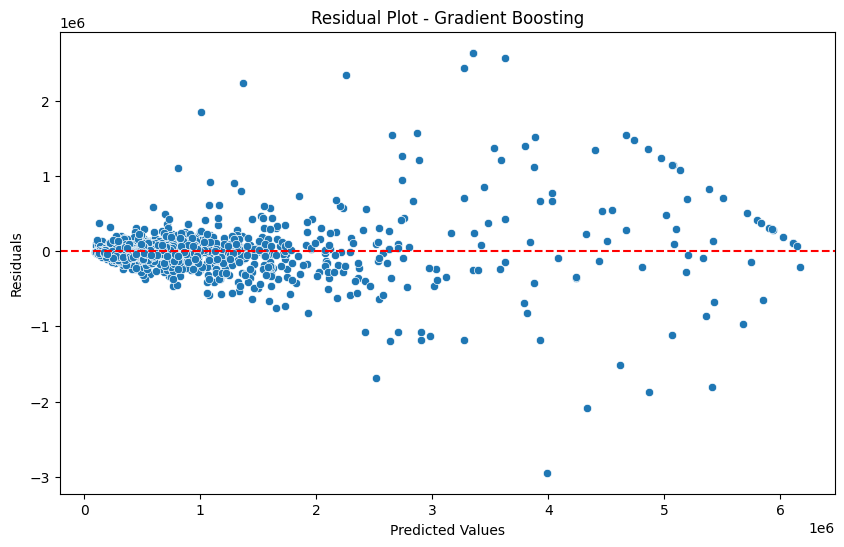

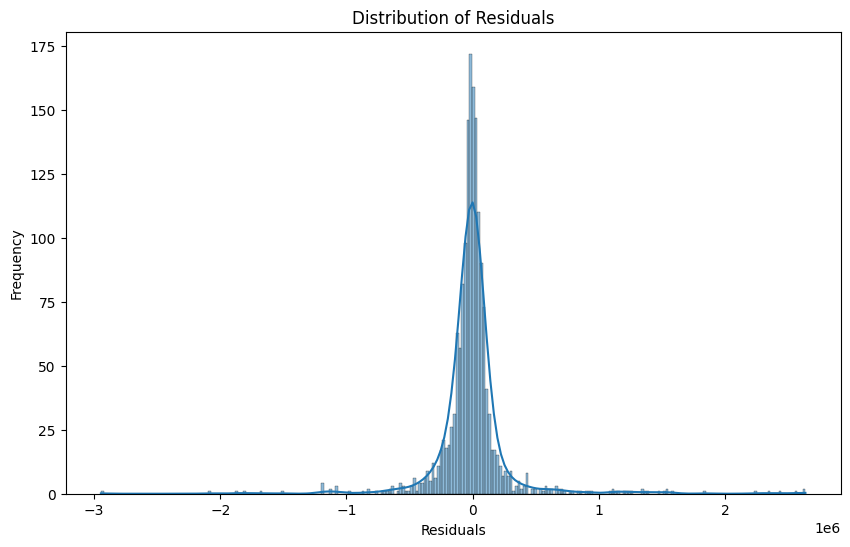

In [197]:
#Calculate residuals
residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')  # Add a horizontal line at y=0
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot - Gradient Boosting")
plt.show()

# 10. Optional: Check for homoscedasticity (constant variance)
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals")
plt.show()

Model Optimization


In [199]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Assuming 'df' is your cleaned DataFrame


features = ["Registration Year", "Year of Manufacture", "modelYear", "Kms Driven", "Top Speed", "Engine Displacement", "ownerNo", "Acceleration", "Insurance Validity", "Fuel Type", "Transmission", "Ownership", "oem", "model", "Color", "Seating Capacity"]
X = df[features]
y = df['price']


# 2. Remove Completely Empty Columns
cols_to_remove = ['Seats', 'priceActual', 'priceSaving', 'priceFixedText', 'Max Power',
                   'Drive Type', 'Front Brake Type', 'Rear Brake Type', 'Tyre Type', 'Mileage',
                   'Value Configuration', 'Super Charger', 'BoreX Stroke']

X_cleaned = X.drop(columns=cols_to_remove, errors='ignore')

# Handle categorical features using Label Encoding
encoders = {}
for col in X.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X.loc[:, col] = le.fit_transform(X[col]) # use .loc to prevent SettingWithCopyWarning
    encoders[col] = le

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)
X_imputed = pd.DataFrame(X_imputed, columns=X.columns)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

# 6. Scaling (Important for Lasso and Ridge)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ----------------------------------------------------------------------------------
# Lasso Regression
# ----------------------------------------------------------------------------------
lasso_param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100]  # Regularization strength
}

lasso_grid_search = GridSearchCV(Lasso(max_iter=10000), lasso_param_grid, cv=3, scoring='neg_mean_squared_error')
lasso_grid_search.fit(X_train_scaled, y_train)
lasso_model = lasso_grid_search.best_estimator_

y_pred_lasso = lasso_model.predict(X_test_scaled)
rmse_lasso = root_mean_squared_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)

cv_scores_lasso = cross_val_score(lasso_model, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')
cv_rmse_scores_lasso = np.sqrt(-cv_scores_lasso)

print("Lasso Regression:")
print(f"  Test Set RMSE: {rmse_lasso}")
print(f"  Test Set R-squared: {r2_lasso}")
print(f"  Cross-Validation RMSE Scores: {cv_rmse_scores_lasso}")
print(f"  Mean Cross-Validation RMSE: {cv_rmse_scores_lasso.mean()}")
print(f"  Standard Deviation of Cross-Validation RMSE: {cv_rmse_scores_lasso.std()}")
print(f"  Best parameters: {lasso_grid_search.best_params_}")
print("------------------------")

# ----------------------------------------------------------------------------------
# Ridge Regression
# ----------------------------------------------------------------------------------
ridge_param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100]  # Regularization strength
}

ridge_grid_search = GridSearchCV(Ridge(), ridge_param_grid, cv=3, scoring='neg_mean_squared_error')
ridge_grid_search.fit(X_train_scaled, y_train)
ridge_model = ridge_grid_search.best_estimator_

y_pred_ridge = ridge_model.predict(X_test_scaled)
rmse_ridge = root_mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

cv_scores_ridge = cross_val_score(ridge_model, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')
cv_rmse_scores_ridge = np.sqrt(-cv_scores_ridge)

print("Ridge Regression:")
print(f"  Test Set RMSE: {rmse_ridge}")
print(f"  Test Set R-squared: {r2_ridge}")
print(f"  Cross-Validation RMSE Scores: {cv_rmse_scores_ridge}")
print(f"  Mean Cross-Validation RMSE: {cv_rmse_scores_ridge.mean()}")
print(f"  Standard Deviation of Cross-Validation RMSE: {cv_rmse_scores_ridge.std()}")
print(f"  Best parameters: {ridge_grid_search.best_params_}")
print("------------------------")

Lasso Regression:
  Test Set RMSE: 660375.9446024197
  Test Set R-squared: 0.618445889929826
  Cross-Validation RMSE Scores: [634125.44014502 624967.13452543 606166.20887066 648525.8219317
 603328.12448971]
  Mean Cross-Validation RMSE: 623422.5459925026
  Standard Deviation of Cross-Validation RMSE: 17021.62804346213
  Best parameters: {'alpha': 10}
------------------------
Ridge Regression:
  Test Set RMSE: 660390.8125216173
  Test Set R-squared: 0.6184287088692941
  Cross-Validation RMSE Scores: [634053.64178573 624937.16025542 606192.75578289 648508.97077025
 603398.15658819]
  Mean Cross-Validation RMSE: 623418.1370364946
  Standard Deviation of Cross-Validation RMSE: 16985.197712998182
  Best parameters: {'alpha': 1}
------------------------


Model Comparison: Random Forest, Linear Regression, and Gradient Boosting

Gradient Boosting (Best Performer):
Performance: Gradient Boosting exhibits the best performance with the lowest Test Set RMSE (281581.50) and the highest Test Set R-squared (0.9306). This indicates it provides the most accurate predictions and explains the largest variance in the target variable.
Cross-Validation: The cross-validation scores are also strong, with a relatively low Mean Cross-Validation RMSE (279437.97) and a reasonable standard deviation.
Feature Importance: Gradient Boosting provides a good insight into the features most relevant to the prediction. Engine Displacement, modelYear, and Transmission are the top 3 most important features.
Tuning: The best parameters indicate that a learning rate of 0.2, a max depth of 4 and 300 estimators, produced the best results.
Random Forest (Good Performer):
Performance: Random Forest performs well, with a Test Set RMSE of 315884.37 and an R-squared of 0.9127. It's close to Gradient Boosting in accuracy.
Cross-Validation: The cross-validation scores show consistency, with a Mean Cross-Validation RMSE of 319136.80.
Feature Importance: Similar to Gradient Boosting, Engine Displacement, modelYear, and Transmission are highly influential.
Tuning: The best parameters indicate that 300 estimators with no max depth limit and a minimum samples split of 2 produced the best results.
Linear Regression (Poor Performer):
Performance: Linear Regression performs significantly worse than the tree-based models, with a much higher Test Set RMSE (660373.22) and a lower R-squared (0.6184).
Cross-Validation: The cross-validation scores also reflect this poor performance.
Limitations: Linear Regression assumes a linear relationship between features and the target, which may not hold true for this dataset.
Elaboration of Lasso and Ridge Regression

Both Lasso and Ridge Regression are regularized linear regression techniques designed to address overfitting and improve model generalization. They achieve this by adding a penalty term to the standard linear regression cost function.

Ridge Regression (L2 Regularization):
Ridge Regression adds a penalty proportional to the square of the magnitude of the coefficients.
This penalty shrinks the coefficients towards zero but rarely forces them to be exactly zero.
Ridge is effective in reducing the impact of multicollinearity (high correlation between features).
Results: Ridge regression had a very similar, and poor, result as the regular linear regression.
Lasso Regression (L1 Regularization):
Lasso Regression adds a penalty proportional to the absolute value of the magnitude of the coefficients.
This penalty can force some coefficients to be exactly zero, effectively performing feature selection.
Lasso is useful when you suspect that many features are irrelevant.1   
1.
github.com
github.com
Results: Lasso regression had a very similar, and poor, result as the regular linear regression.
Why Linear, Lasso and Ridge performed poorly:
The relationship between vehicle features and price is likely highly non-linear. Tree based models, like Random Forest and Gradient Boosting, are excellent at modeling non-linear data.
The features may have complex interactions that linear models can't capture.
Key Takeaways

Tree-based models (Gradient Boosting and Random Forest) outperformed linear models (Linear, Lasso, and Ridge Regression) significantly.
Gradient Boosting was the most accurate model, followed closely by Random Forest.
Feature importance analysis reveals that Engine Displacement, modelYear, and Transmission are crucial predictors of vehicle price.
Linear models were very poor predictors of the price, indicating that the data is highly non-linear.
Lasso and Ridge regression provided no significant improvement over the base linear regression.

In [11]:
with open('gradient_boosting_model.pkl', 'wb') as file:
    pickle.dump(gb_model, file)

with open('imputer.pkl', 'wb') as file:
    pickle.dump(imputer, file)

column_names = X_train.columns.tolist()

with open('column_names.pkl', 'wb') as file:
    pickle.dump(column_names, file)

print("Gradient Boosting model, imputer, and column names saved as pickle files.")

Gradient Boosting model, imputer, and column names saved as pickle files.


In [12]:
import pickle

model_path = r'D:\Data Science\Python.VS\sownd\project 3 cardekho\gradient_boosting_model.pkl'

try:
    with open(model_path, 'rb') as file:
        loaded_model = pickle.load(file)
    print(f"Model loaded successfully. Type: {type(loaded_model)}")
except Exception as e:
    print(f"Error loading model: {e}")

Model loaded successfully. Type: <class 'sklearn.ensemble._gb.GradientBoostingRegressor'>


In [13]:
model_path = r'D:\Data Science\Python.VS\sownd\project 3 cardekho\gradient_boosting_model.pkl'
with open(model_path, 'rb') as file:
    model = pickle.load(file)
print(f"Model type: {type(model)}")  # Add this line!

Model type: <class 'sklearn.ensemble._gb.GradientBoostingRegressor'>


In [14]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import pickle

# Load your training data
train_data = pd.read_csv('final_cleaned_data.csv') #replace with your file name.

# Identify categorical columns
categorical_cols = ['Insurance Validity', 'Color', 'Fuel Type', 'Transmission', 'Ownership', 'oem', 'model'] #add all your categorical columns.

# Create and fit label encoders
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    train_data[col] = train_data[col].astype(str) #convert to string.
    le.fit(train_data[col])
    label_encoders[col] = le

# Save label encoders
with open('label_encoders.pkl', 'wb') as file:
    pickle.dump(label_encoders, file)

print('label_encoders.pkl created successfully!')

label_encoders.pkl created successfully!
